In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy.signal import savgol_filter
import topsispy as tp
from IPython.display import clear_output
from IPython.display import Image
#!pip install deap
             

# Data Loading and preparing

In [2]:
I=np.load("Im.npy",allow_pickle=True)
V=np.load("Vm.npy",allow_pickle=True)
T=np.load("Tm.npy",allow_pickle=True)
SOC=np.load("SOCm.npy",allow_pickle=True)
time=np.load("timem.npy",allow_pickle=True)

In [3]:
I1=np.load("I.npy",allow_pickle=True)
V1=np.load("V.npy",allow_pickle=True)
T1=np.load("T.npy",allow_pickle=True)
SOC1=np.load("SOC.npy",allow_pickle=True)

In [4]:
train_data=[I,V,T,SOC]

In [5]:
I=[]
V=[]
T=[]
SOC=[]
time=[]
for i in range(len(train_data[0])):
    for j in range(len(train_data[3][i])):
        I.append(train_data[0][i][j])
        V.append(train_data[1][i][j])
        T.append(train_data[2][i][j])
        SOC.append(train_data[3][i][j])
        #time.append(train_data[4][i][j])

In [6]:
df_train=pd.DataFrame({"I":I,"V":V,"T":T,"SOC":SOC})

In [7]:
mini,minv,mint,maxi,maxv,maxt=np.load("min_max_soc.npy")

In [8]:
df_train["I"]=(df_train["I"]-mini)/(maxi-mini)
df_train["V"]=(df_train["V"]-minv)/(maxv-minv)
df_train["T"]=(df_train["T"]-mint)/(maxt-mint)

In [9]:
def split_sequence(sequence, input_steps, output_steps):
    X = []
    y = []
    time=[]
    
    for i in range(len(sequence) - input_steps - output_steps + 1):
        X.append(np.array(sequence.iloc[i:i+input_steps, :3]))
        time.append(np.array(sequence.iloc[i:i+input_steps,3]))
        y.append(np.array(sequence.iloc[i+input_steps:i+input_steps+output_steps]["SOC"]))

    return X,y,time

In [10]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
input_step=100
output_step=25
X_train,Y_train,time=split_sequence(df_train,input_step,output_step)

In [11]:
t=np.zeros((len(X_train),3,100))
for i in range(len(X_train)):
    for j in range(100):
        t[i][0][j]=X_train[i][j][0]
        t[i][1][j]=X_train[i][j][1]
        t[i][2][j]=X_train[i][j][2]
    

In [12]:
X1=np.float32(X_train)
Y1=np.float32(Y_train)

In [13]:
model=load_model("soc_simple_prediction1.h5") # model for SOC estimation

In [14]:
np.save("original_soc",Y1) # saving the data to use it after in the Ontology

# Data Points Used for Method Testing and Knowledge Extraction

1. **Beginning of Charge**: First 100 values (Index = 0)
2. **Middle of Charge**: Point corresponding to the middle of the charging process (index = 150).
3. **SOC Near 100%**: Point where the State of Charge (SOC) is near 100% (index = 350).
4. **Constant Current Discharge**: Point during discharging with constant current.
5. **Non-Constant Current Discharge**: Point during discharging with non-constant current (index = 4700).

These data points are crucial for evaluating the method and extracting meaningful insights from the battery's performance during different stages of charge and discharge.

In [ ]:
Image(filename='C:\\Users\\sarbaoui01\\OneDrive - INSA Strasbourg\\Desktop\\Counterfactuals\\Testing points.png')

In [14]:
def fitness_func(query_instance1, solution,dnr):
    d =  np.linalg.norm(query_instance1-solution)
    pr1=model.predict(np.reshape(query_instance1,(1,100,3)),verbose=0)
    pr2=model.predict(np.reshape(solution,(1,100,3)),verbose=0)
    correlation_matrix = np.corrcoef(pr1, pr2)
    y= np.linalg.norm(pr1-pr2)
    if (y==0):
        fitness=np.infty
    else:
        if (dnr==0):
            fitness=np.infty
        else:
            fitness =(d/y)+(1/dnr)*0
    
    return fitness,d,y,dnr,correlation_matrix[1, 1]

In [15]:
def nearest_neighbor_distance(p,c,j):
    min_d=np.inf
    index=0
    for i in range(len(p)):
        if(j!=i):
            d =  np.linalg.norm(p[i]-c)
            if(min_d>d):
                index=i
                min_d=d
    return min_d,index

In [16]:
def filtering(data):
    dt=[]
    while(len(data)!=0):
        dt.append(data[0])
        d=data[1:]
        df=[]
        for i in range(len(d)):
            if(np.linalg.norm(d[i]-dt[-1])!=0):
                df.append(d[i])
        data=df
    return dt
            
        
            

In [17]:
def selection(data,sign,weights):
    d=[]
    f=[]
    pro=[]
    validity=[]
    diversity=[]
    for i in tqdm(range(len(data)), desc="selection..."):
        d.append(np.reshape(data[i],(100,3)))
        min_d=nearest_neighbor_distance(data,data[i],i)
        pro.append(fitness_func(query_instance1,data[i],min_d[0])[1])
        validity.append(fitness_func(query_instance1,data[i],min_d[0])[2])
        diversity.append(fitness_func(query_instance1,data[i],min_d[0])[3])
        f.append(fitness_func(query_instance1,data[i],min_d[0])[0])
    matrix=np.transpose([validity,pro,diversity])   #validity(maximize),proximity(minimize),diversity(maximize)
    rank=tp.topsis(matrix, weights, sign)
    df=pd.DataFrame({"data":d,"f":rank[1]})
    df=df.sort_values(by=['f'],ascending=False)
    t=df.head(n=20)
    t=np.array(t['data'])
    t2=np.zeros((20,100,3))
    for i in range(20):
        for j in range(100):
            for k in range(3):
                t2[i][j][k]=t[i][j][k]
    return t2

In [18]:
def generate(data,prob=0.8):
    new_generation = []
    if(random.random()<prob):
        for l in tqdm(range(20), desc="generating..."):
            pi1 = random.randint(0, len(data) - 1)
            pi2 = random.randint(0, len(data) - 1)
            p1 = data[pi1]
            p2 = data[pi2]
            # Generate a random feature number 
            b=random.randint(0,99)
            f= [0,1,2]
            e=random.randint(b,min(b+20,100))
            for i in f:
                for j in range(b,e):
                    k = p1[j][i]
                    p1[j][i] = p2[j][i]
                    p2[j][i] = k
            new_generation.append(np.reshape(p1,(100,3)))
            new_generation.append(np.reshape(p2,(100,3)))
    return new_generation

In [19]:
def mutation(data, prob=0.2):
    muta = []
    if random.random() < prob:
        for j in tqdm(range(5), desc="mutation..."):
            individual = data[random.randint(0, len(data) - 1)]
            individual = np.reshape(individual, (100, 3))
            feature = random.choice([0, 1, 2])  # shape: (3,100)
            x = individual[feature]
            xl = 0
            xu = 1
            rand = random.random()

            # Randomly determine whether to push towards lower or upper boundary
            mutation_amount = random.uniform(-0.2, 0.2)  # Allow both decrease and increase
            x = np.clip(x + mutation_amount, 0, 1)  # Ensure values stay within [0, 1]
    
            individual[feature] = x
            muta.append(np.reshape(individual, (100, 3)))
           

    return muta

In [20]:
def evaluate(data):
    c=[]
    m=np.inf
    index=0
    for i in tqdm(range(len(data)), desc="evaluating..."):
        min_d=nearest_neighbor_distance(data,data[i],i)
        f=fitness_func(query_instance1,data[i],min_d[0])[0]
        if(f<m):
            m=f
            index=i
    return m,index

In [21]:

def conterfactual_generation(population,query_instance1):
    r=population
    a=[1,2,3]
    iteration=0
    index=0
    metric=0
    best_population=r
    previous_metric=np.inf
    sign = [1, -1, 1]
    weights=[0.3,0.6,0.10]
    while(not is_convergent(a) and iteration<=50 ):
        f=selection(r,sign,weights)
        
        r=generate(f)
    
        if(len(r)!=0):
            r=np.concatenate((f, r), axis=0)
        else:r=f
        m=mutation(r)
        if(len(m)!=0):
            r=np.concatenate((r, m), axis=0)
        d=[]
        f=[]
        pro=[]
        validity=[]
        diversity=[]
        for i in tqdm(range(len(r)), desc="filtering..."):
            d.append(r[i])
            min_d=nearest_neighbor_distance(r,r[i],i)
            pro.append(fitness_func(query_instance1,r[i],min_d[0])[1])
            validity.append(fitness_func(query_instance1,r[i],min_d[0])[2])
            diversity.append(fitness_func(query_instance1,r[i],min_d[0])[3])
            f.append(fitness_func(query_instance1,r[i],min_d[0])[0])
            
        matrix=np.transpose([validity,pro,diversity])  
        rank=tp.topsis(matrix, weights, sign)
        df=pd.DataFrame({"data":d,"f":rank[1]})
        df=df.sort_values(by=['f'],ascending=False)
        r=np.array(df['data'])
        r=filtering(r)
        metric,index=evaluate(r)
        if(metric<=previous_metric):
            previous_metric=metric
            best_population=r
        r=best_population    
        if(metric<=previous_metric):
            a.append(metric)
        else:a.append(previous_metric)
        iteration+=1
        clear_output(wait=True)
    return best_population,index,a

In [22]:
def is_convergent(array, tolerance=1e-6):
    a=0
    for i in range(1, len(array)):
        if abs(array[i] - array[i-1]) > tolerance:
            a=0
        else:
            a=a+1
    if(a>=50):
         return True
    else :
        return False
   

In [23]:
def distence(x1,x2):
       return  np.linalg.norm(x1-x2)
    

In [24]:
def prediction_d(x1,x2):
    pr1=model.predict(np.reshape(x1,(1,100,3)),verbose=0)
    pr2=model.predict(np.reshape(x2,(1,100,3)),verbose=0)
    y= np.linalg.norm(pr1-pr2)
    return y

In [25]:
def Plot_fitness(a):
    ax=plt.figure(figsize=(10, 5))
    plt.plot(a[3:])
    plt.xlabel('Generation')
    plt.ylabel('best fitness value')
    plt.grid(color='#2A3459')
    ax.set_facecolor('white')
    plt.title('Evolution of fitness values over time')

In [26]:
def Plot_Difference(query_instance1,cefs,index):
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    original_series=query_instance1
    counterfactual_series=cefs[index]
    # Assuming original_series and counterfactual_series are of shape (100, 3)
    abs_per_feature = [np.sum(np.abs(original_series[:, i]-counterfactual_series[:, i]))/100 for i in range(3)]
    ab= [np.abs(original_series[:, i]-counterfactual_series[:, i])/100 for i in range(3)]
    dfi= ab[0]
    dfv = ab[1]
    dft = ab[2]
    ax=plt.figure(figsize=(10, 5))
    plt.plot(dfi, label='I Différence par point temporel')
    plt.plot(dfv, label='V Différence par point temporel')
    plt.plot(dft, label='T Différence par point temporel')
    plt.xlabel('Pas de temps')
    plt.ylabel('Différence')
    plt.grid(color='#2A3459')
    plt.legend()
    ax.set_facecolor('white')
    plt.show()

In [27]:
feature_names = ["I", "V","T"]
def Plot_Difference_per_feature(query_instance1,cefs,index,feature_names):
    original_series=query_instance1
    counterfactual_series=cefs[index]
    abs_per_feature = [np.sum(np.abs(original_series[:, i]-counterfactual_series[:, i]))/100 for i in range(3)]
    ab= [np.abs(original_series[:, i]-counterfactual_series[:, i])/100 for i in range(3)]
    ax=plt.figure(figsize=(10, 5))
    plt.bar(feature_names, abs_per_feature, color='skyblue')
    plt.xlabel('Attributs')
    plt.ylabel('MAE')
    plt.grid(color='#2A3459')
    plt.title('Comparaison du MAE par Attribut')
    ax.set_facecolor('white')
    plt.show()

In [28]:
def compare(x1,x2,time,f,name):
    names=["I","V","T"]
    feature=np.where(np.array(names) ==f)[0][0]
    d1=[x1[i][feature] for i in range(time,100)]
    d2=[x2[i][feature] for i in range(time,100)]
    plt.style.use("classic")
    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        '#F5D300',  # yellow
        '#00ff41',  # matrix green
    ]
    df = pd.DataFrame({'Données originales': list(d1),
                       'Données contrefactuelles': list(d2)})
    fig, ax = plt.subplots(figsize=(10,5))
    df.plot(marker='.', color=colors, ax=ax)
    ax.grid(color='#2A3459')
    plt.xlabel('Pas de temps', fontweight = 'bold', fontsize='large')
    plt.ylabel('Valeurs normalisées', fontweight = 'bold', fontsize='large')
    plt.title("Comparaison entre les valeurs originales et contrefactuelles de l'attribut "+f)
    plt.legend(loc='lower right')
    fig.set_facecolor('white')
    plt.show()

In [29]:
def Make_prediction(query_instance1,cefs,index):
    pr1=model.predict(np.reshape(cefs[0],(1,100,3)),verbose=0)
    pr2=model.predict(np.reshape(query_instance1,(1,100,3)),verbose=0)
    ax=plt.figure(figsize=(10, 5))
    plt.plot(pr1[0],label="EDC Contrefactuel")
    plt.plot(pr2[0],label="EDC Original")
    plt.xlabel('Pas de temps')
    plt.ylabel('EDC')
    plt.grid(color='#2A3459')
    plt.title("Valeurs d'EDC pour le contrefactuel et l'original")
    plt.legend()
    ax.set_facecolor('white')

In [30]:
from mpl_toolkits.mplot3d import Axes3D
def Ploat_Properties(query_instance1,cefs):
    proximity_values = []
    validity_values = []
    diversity_values = []
    r=cefs
    for i in tqdm(range(len(r)), desc="analysing..."):
        min_d=nearest_neighbor_distance(r,r[i],i)
        proximity_values.append(fitness_func(query_instance1,r[i],min_d[0])[1])
        validity_values.append(fitness_func(query_instance1,r[i],min_d[0])[2])
        diversity_values.append(fitness_func(query_instance1,r[i],min_d[0])[3])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the point (x, y, z)
    ax.scatter(proximity_values, validity_values,  diversity_values, color='darkblue', s=30)  # s is the size of the point

    for i in range(len(proximity_values)):
         ax.text(proximity_values[i], validity_values[i],  diversity_values[i], '%d' % i, color='black', fontsize=10)
    # Set labels for axes
    ax.set_xlabel('Proximité')
    ax.set_ylabel('Validité')
    ax.set_zlabel('Diversité')
    fig.set_facecolor('white')

    # Set the title
    ax.set_title('Proximité vs Validité vs Diversité')

    # Display the plot
    plt.show()

In [31]:
def Plot_all_CF(cefs):
    inputs = cefs
    f=["I","V","T"]
    for feature_idx in range(3):
        ax=plt.figure(figsize=(10, 6))

        # Plot the specific feature for all inputs
        for i, input_data in enumerate(inputs):
            plt.plot(input_data[:, feature_idx], label=f'CF {i}')

        plt.title(f'Comparaison entre les valeurs contrefactuelles de {f[feature_idx]}')
        plt.xlabel('Pas de temps')
        plt.ylabel(f'Valeurs normalisées')
        ax.set_facecolor('white')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Inputs')
        plt.grid(True)
        plt.show()

In [120]:
from time import time
def GENO_TOPSIS_method_results(query_instance1,population):
    t0=time()
    cefs,index,a=conterfactual_generation(population,query_instance1)
    t1 = time()
    print("number of cf generated:",len(cefs))
    print("Time needed in s:",(t1-t0))
    Plot_fitness(a)
    Plot_Difference(query_instance1,cefs,index)
    Plot_Difference_per_feature(query_instance1,cefs,index,feature_names)
    i=index
    compare(query_instance1,cefs[i],0,"I","GA")
    compare(query_instance1,cefs[i],0,"V","GA")
    compare(query_instance1,cefs[i],0,"T","GA")
    Make_prediction(query_instance1,cefs,index)
    Ploat_Properties(query_instance1,cefs)
    Plot_all_CF(cefs)
    return cefs
    
    

In [42]:
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification


def init_individual(icls, points, index):
    individual = icls(points[index])
    return individual

def init_population(pcls, ind_init, points):
    return pcls(ind_init(creator.Individual, points, i) for i in range(len(points)))



def custom_crossover(ind1, ind2):
    if(np.ndim(ind1)==2 and np.ndim(ind2)==2):
        cxpoints = random.randint(1, min(np.shape(ind1)[1],np.shape(ind2)[1]) - 1)
        cxpointe =random.randint(cxpoints, min(np.shape(ind1)[1],np.shape(ind2)[1]) - 1)
        cxfe = random.randint(0, 3 - 1)
        ind1[0][cxpoints:cxpointe], ind2[0][cxpoints:cxpointe] = ind2[0][cxpoints:cxpointe], ind1[0][cxpoints:cxpointe]
        ind1[1][cxpoints:cxpointe], ind2[1][cxpoints:cxpointe] = ind2[1][cxpoints:cxpointe], ind1[1][cxpoints:cxpointe]
        ind1[2][cxpoints:cxpointe], ind2[2][cxpoints:cxpointe] = ind2[2][cxpoints:cxpointe], ind1[2][cxpoints:cxpointe]
    return ind1, ind2
def evaluate2(individual):
    individual = np.array(individual).reshape(3,100)
    proximity = np.linalg.norm(individual - ID)
    original_pred = model.predict(np.reshape(ID,(1,100,3)),verbose=0)[0]
    ctf_pred = model.predict(np.reshape(individual,(1,100,3)),verbose=0)[0]
    validity = np.linalg.norm(original_pred - ctf_pred)
    if (len(population) > 1):
        reshaped_population = np.array([ind.reshape(3,100) for ind in population if not np.array_equal(ind, individual)])
        reshaped_individual = individual.reshape(3,100)
        distances = np.linalg.norm([reshaped_individual]-reshaped_population)
        diversity = np.min(distances)
    else:
        diversity = 0  

    return proximity, -validity, -diversity

def mutPolynomialBounded(individual,indpb):
    feature=random.choice([0,1,2])
    if random.random() <= indpb:
            x = individual[feature]
            mutation_amount = random.uniform(-0.2, 0.2) 
            x = np.clip(x + mutation_amount, 0, 1) 
            individual[feature] = x
    return individual
from functools import cmp_to_key

def sortNondominated(individuals, n):
    pareto_fronts = []
    dom_count = {i: 0 for i in range(n)}
    dominated_set = {i: [] for i in range(n)}
    fronts = []

    for i in range(n):
        for j in range(n):
            if i != j:
                if dominates(individuals[i].fitness.values, individuals[j].fitness.values):
                    dominated_set[i].append(j)
                elif dominates(individuals[j].fitness.values, individuals[i].fitness.values):
                    dom_count[i] += 1
    
  
    current_front = []
    for i in range(n):
        if dom_count[i] == 0:
            individuals[i].fitness.rank = 0
            current_front.append(i)
            
    pareto_fronts.append(current_front[:])
    front_idx = 0
    
    while len(pareto_fronts[front_idx]) > 0:
        next_front = []
        for i in pareto_fronts[front_idx]:
            for j in dominated_set[i]:
                dom_count[j] -= 1
                if dom_count[j] == 0:
                    individuals[j].fitness.rank = front_idx + 1
                    next_front.append(j)
        front_idx += 1
        pareto_fronts.append(next_front[:])
   
    
    for front in pareto_fronts[:-1]:
        front.sort(key=lambda x: individuals[x].fitness.values) 
        
    return pareto_fronts[:-1] 

def dominates(fitness1, fitness2):
    return all(f1 <= f2 for f1, f2 in zip(fitness1, fitness2)) and any(f1 < f2 for f1, f2 in zip(fitness1, fitness2))


def customSelectNSGA2(individuals, k):
    pareto_fronts =sortNondominated(individuals, len(individuals))
    selected = []
    current_rank = 0
    while len(selected) < k:
        if current_rank < len(pareto_fronts):
            front = pareto_fronts[current_rank]
            if len(selected) + len(front) <= k:
                selected.extend(front)
            else:
                sorted_front = sorted(front, key=lambda x: np.sum(x.fitness.crowding_dist), reverse=True)
                remaining = k - len(selected)
                selected.extend(sorted_front[:remaining])
        else:
            break
        current_rank += 1
    
    return selected






In [34]:
def Plot_Properties_NSAGA2(pareto_front):
    proximity_values2 = [ind.fitness.values[0] for ind in pareto_front]
    validity_values2 = [-ind.fitness.values[1] for ind in pareto_front]
    diversity_values2 = [-ind.fitness.values[2] for ind in pareto_front]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(proximity_values2, validity_values2,  diversity_values2, color='darkblue', s=50)  # s is the size of the point

    for i in range(len(proximity_values2)):
         ax.text(proximity_values2[i], validity_values2[i],  diversity_values2[i], '%d' % i, color='black', fontsize=10)

    ax.set_xlabel('Proximité')
    ax.set_ylabel('Validité')
    ax.set_zlabel('Diversité')
    fig.set_facecolor('white')

    ax.set_title('Proximité vs Validity vs Diversité')

    plt.show()

In [45]:
from time import time
def NSGA2_method_results(query_instance2,population,index):
    if not hasattr(creator, "FitnessMulti"):
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0,1, 100)
    toolbox.register("individual", init_individual, creator.Individual, population)
    toolbox.register("population", init_population, list, init_individual, population)

    ID=query_instance2
    toolbox.register("mate", custom_crossover)
    toolbox.register("mutate", mutPolynomialBounded, indpb=0.2)
    toolbox.register("select", customSelectNSGA2)
    toolbox.register("evaluate", evaluate2)
    
    population = toolbox.population()
    ngen = 50
    cxpb = 0.8
    mutpb = 0.2

    for gen in tqdm(range(ngen), desc="generating..."): 
        parent_indices  = toolbox.select(population, len(population))
        parents = [population[i] for i in parent_indices]

        offspring = [toolbox.clone(ind) for ind in parents]

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)


        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring
        clear_output(wait=True)

    pareto_front = tools.sortNondominated(population, len(population), first_front_only=False)[0]
    
    t1=np.zeros((100,3))
    for j in range(100):
            t1[j][0]=ID[0][j]
            t1[j][1]=ID[1][j]
            t1[j][2]=ID[2][j]
    t2=np.array(pareto_front)
    Plot_Difference(t1,t2,0)
    Plot_Difference_per_feature(t1,t2,index,feature_names)
    compare(t1,t2[index],0,"I","NSGA")
    compare(t1,t2[index],0,"V","NSGA")
    compare(t1,t2[index],0,"T","NSGA")
    Make_prediction(t1,t2,index)
    Plot_Properties_NSAGA2(pareto_front)
    Plot_all_CF(t2)
    return t2

## Beginning of Charge:  (Index = 0)

In [47]:
query_instance1=X1[0]
ID=t[0]
population = X1[1:101]

### GENO-TOPSIS

number of cf generated: 20
Time needed in s: 1939.4686479568481


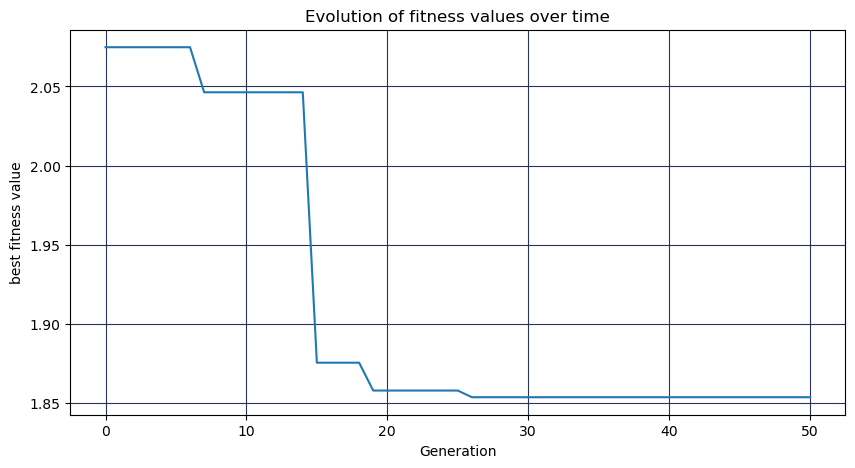

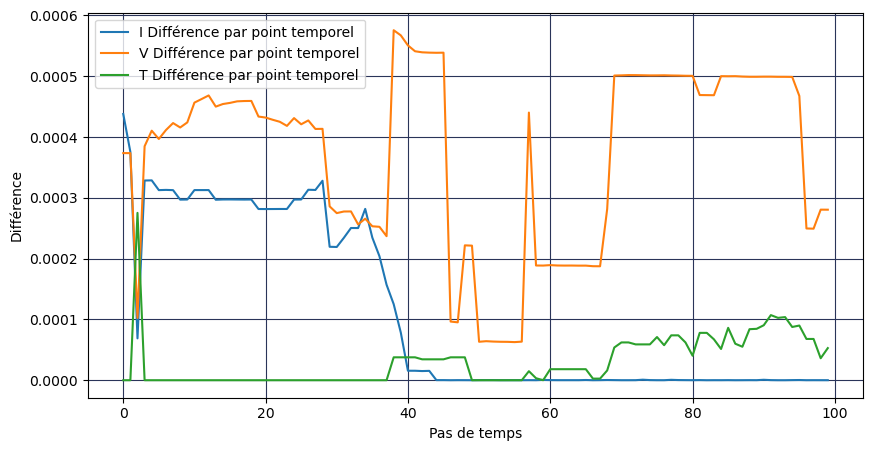

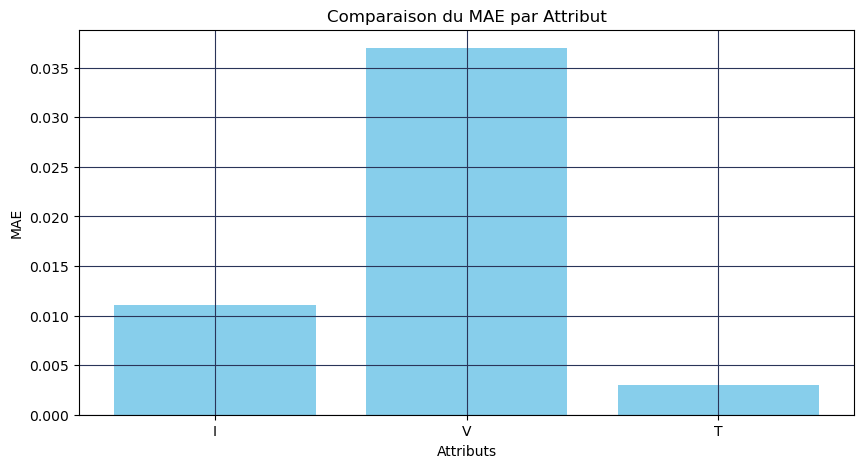

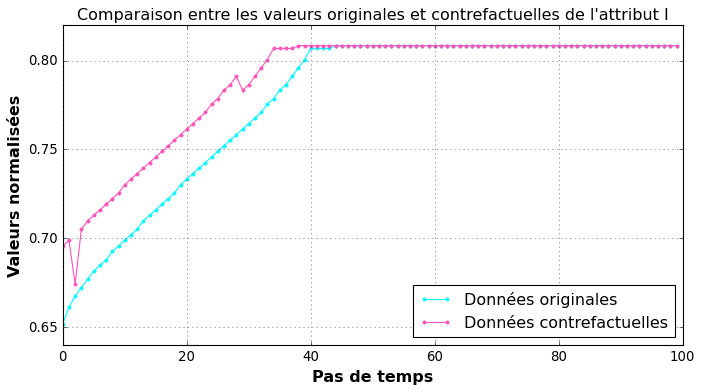

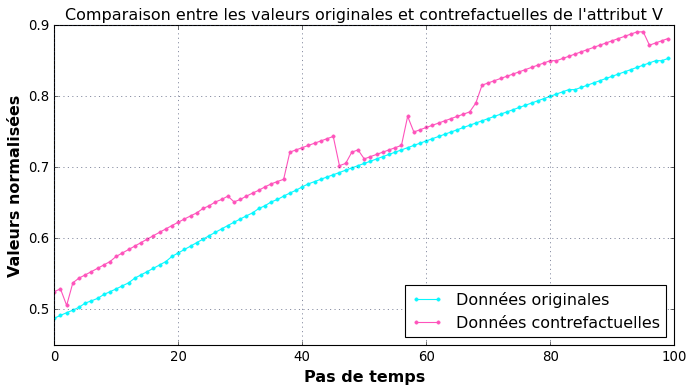

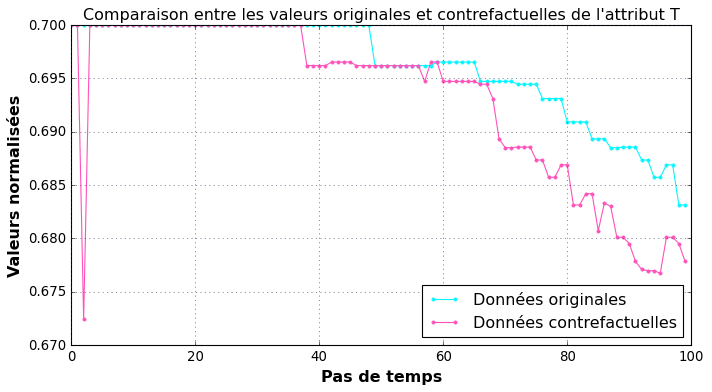

analysing...: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


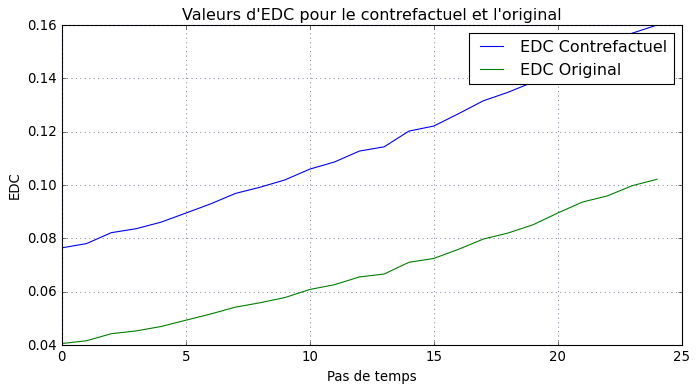

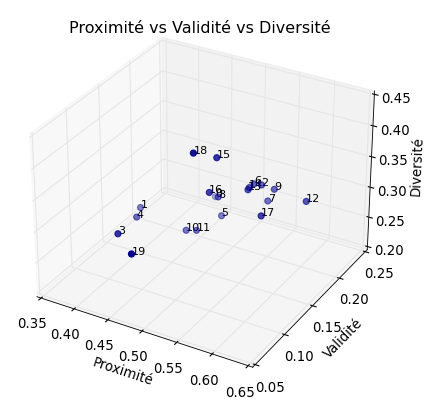

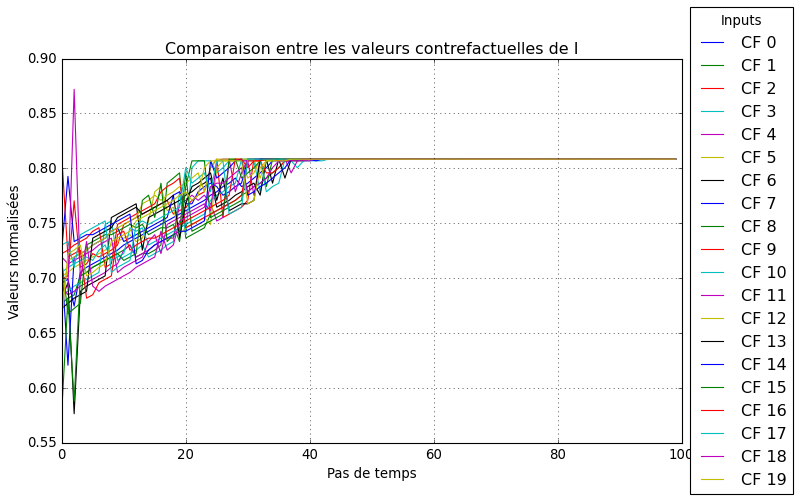

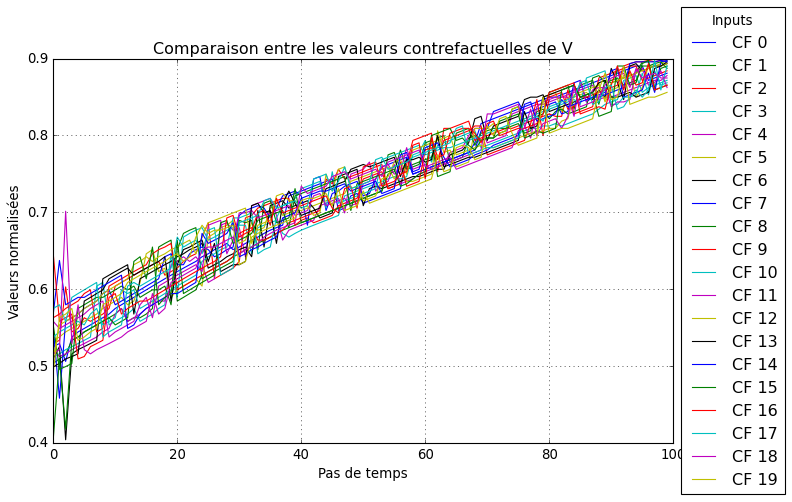

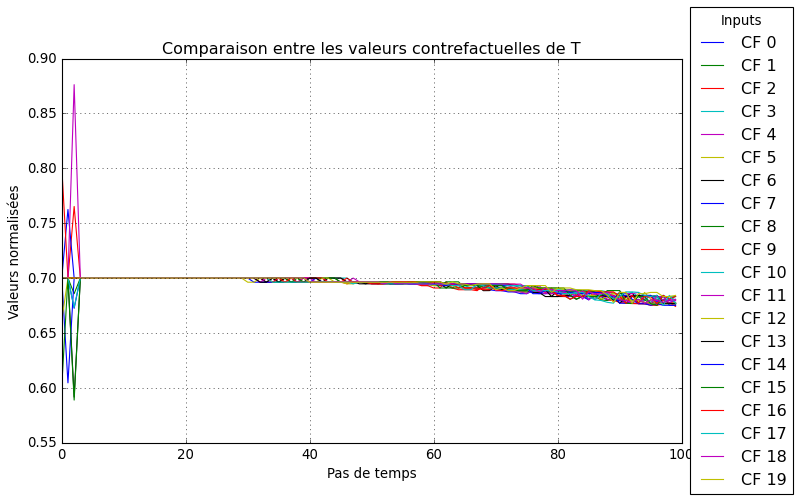

In [38]:
_=GENO_TOPSIS_method_results(query_instance1,population)

### NSGA2

generating...: 100%|███████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.60s/it]


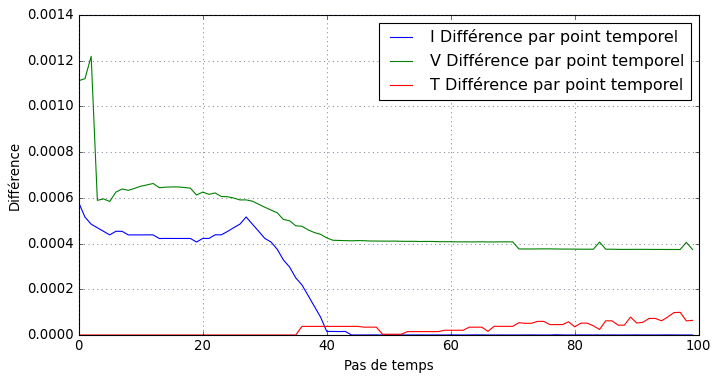

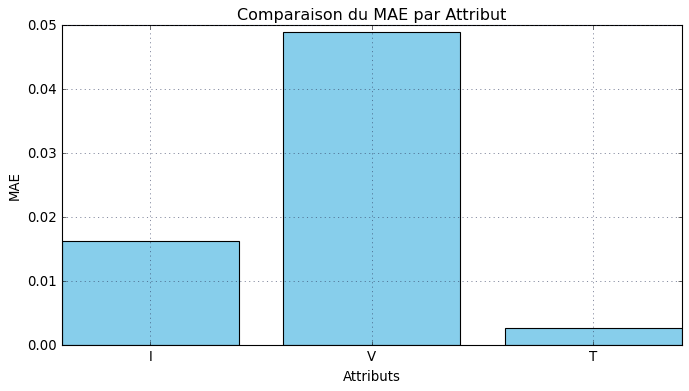

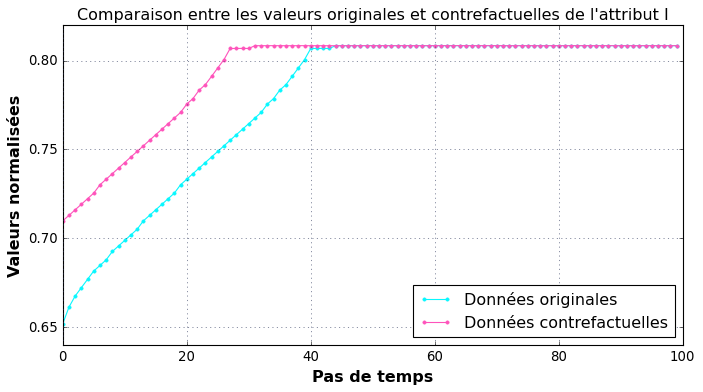

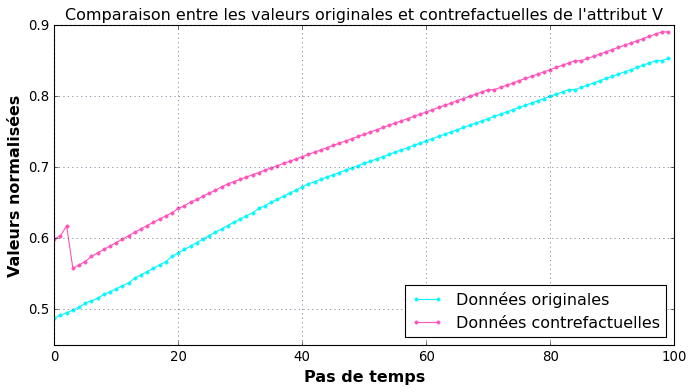

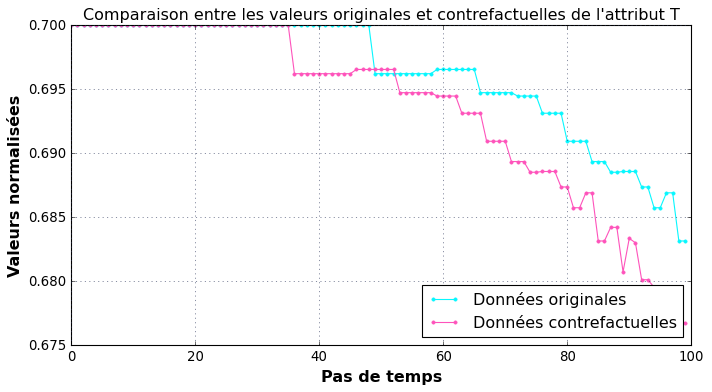

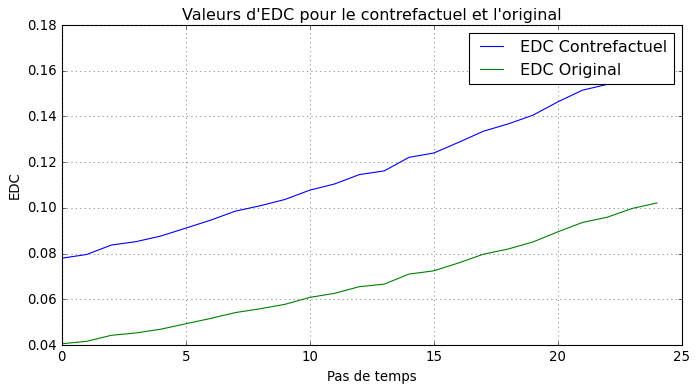

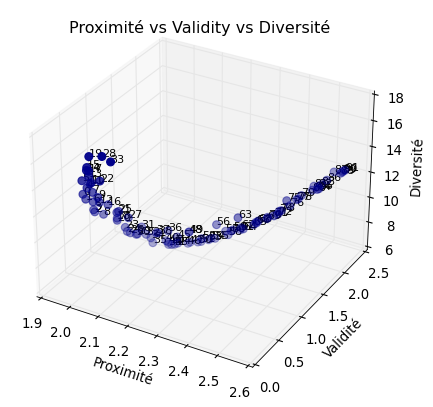

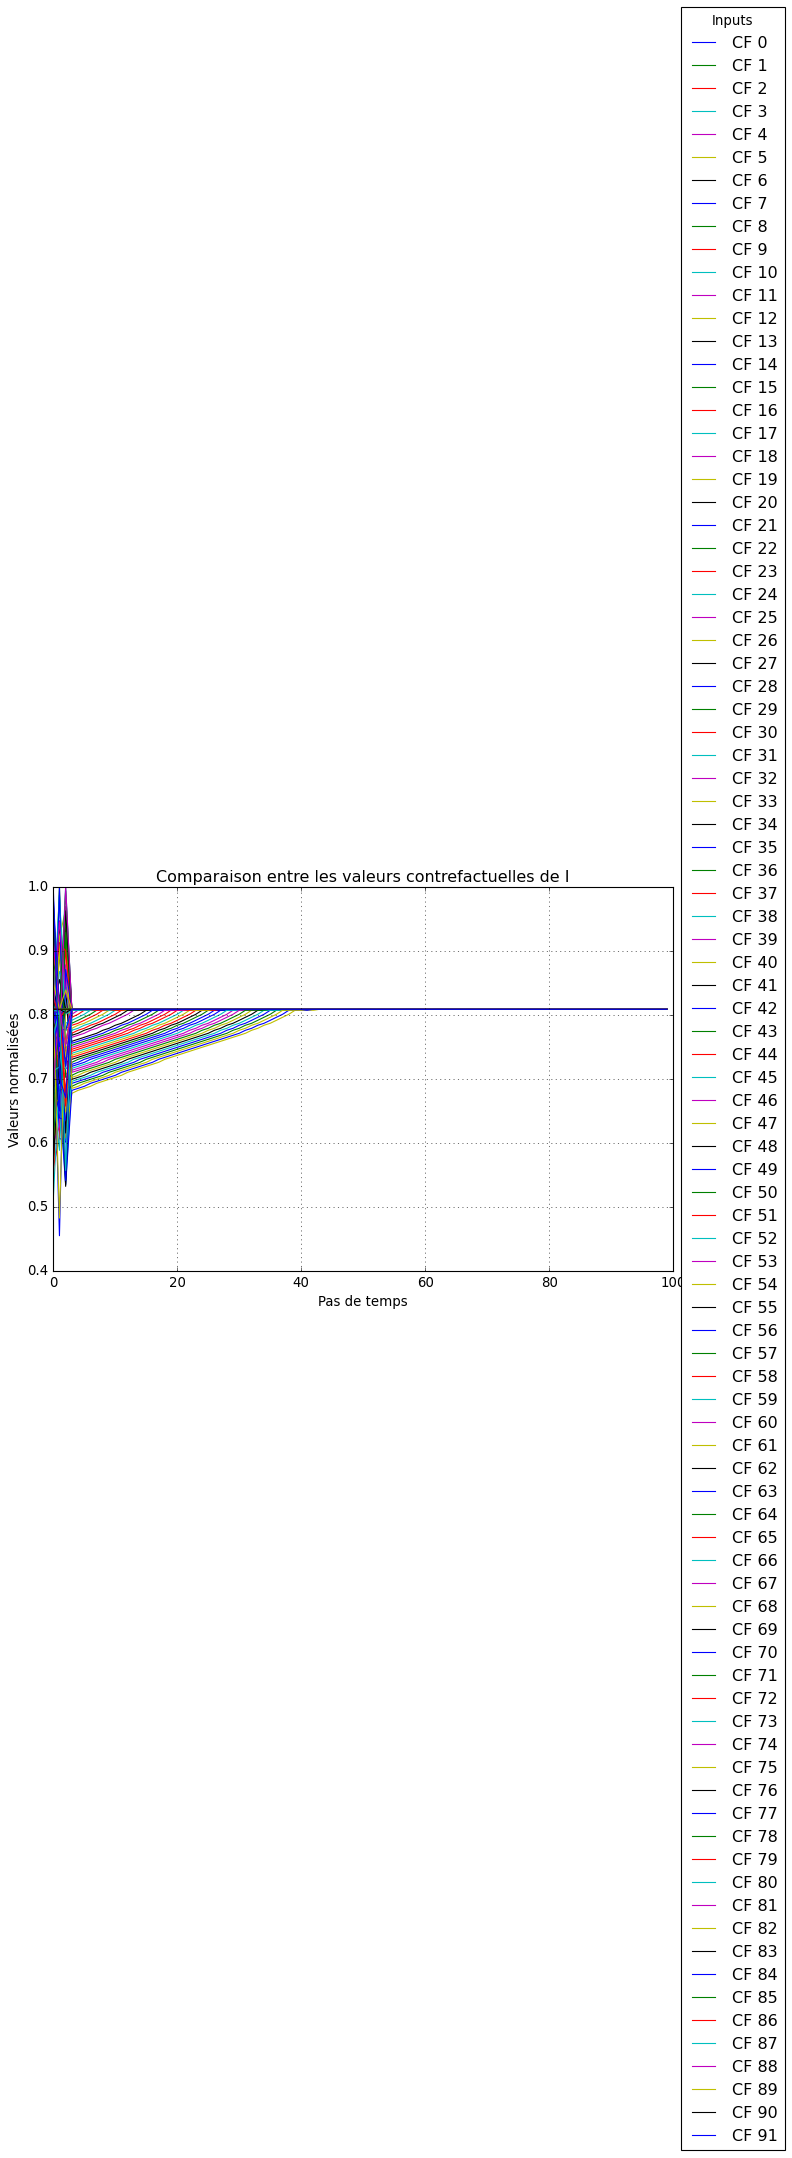

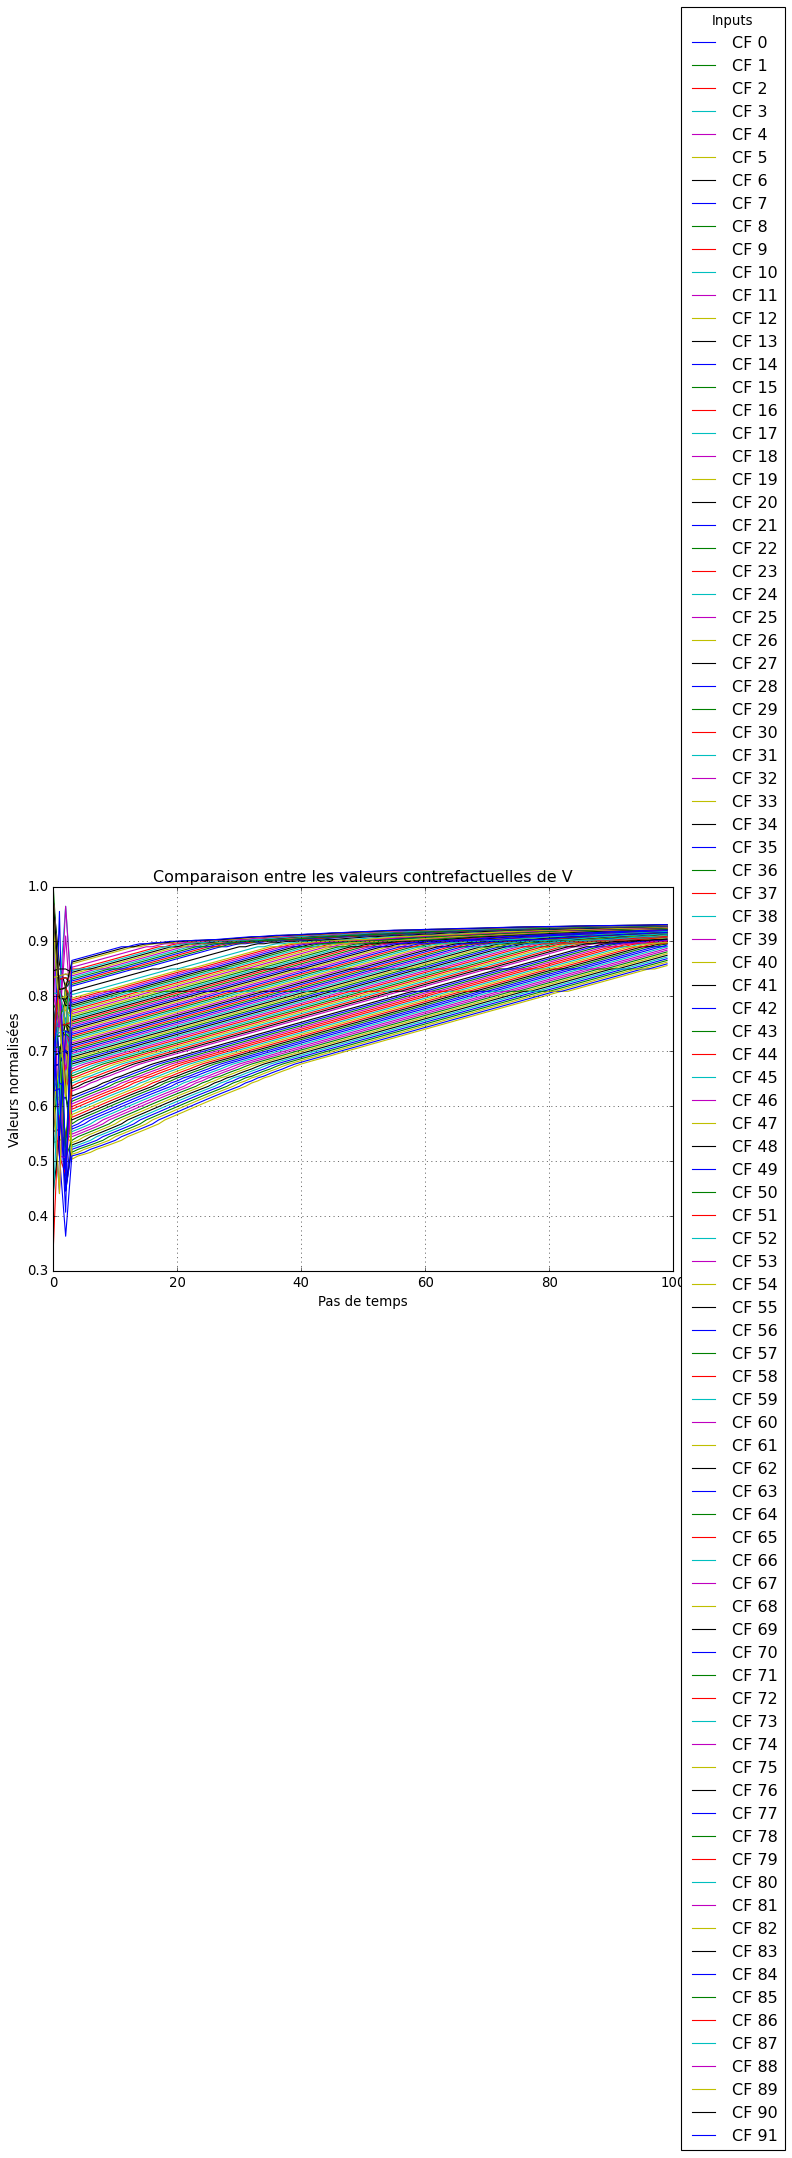

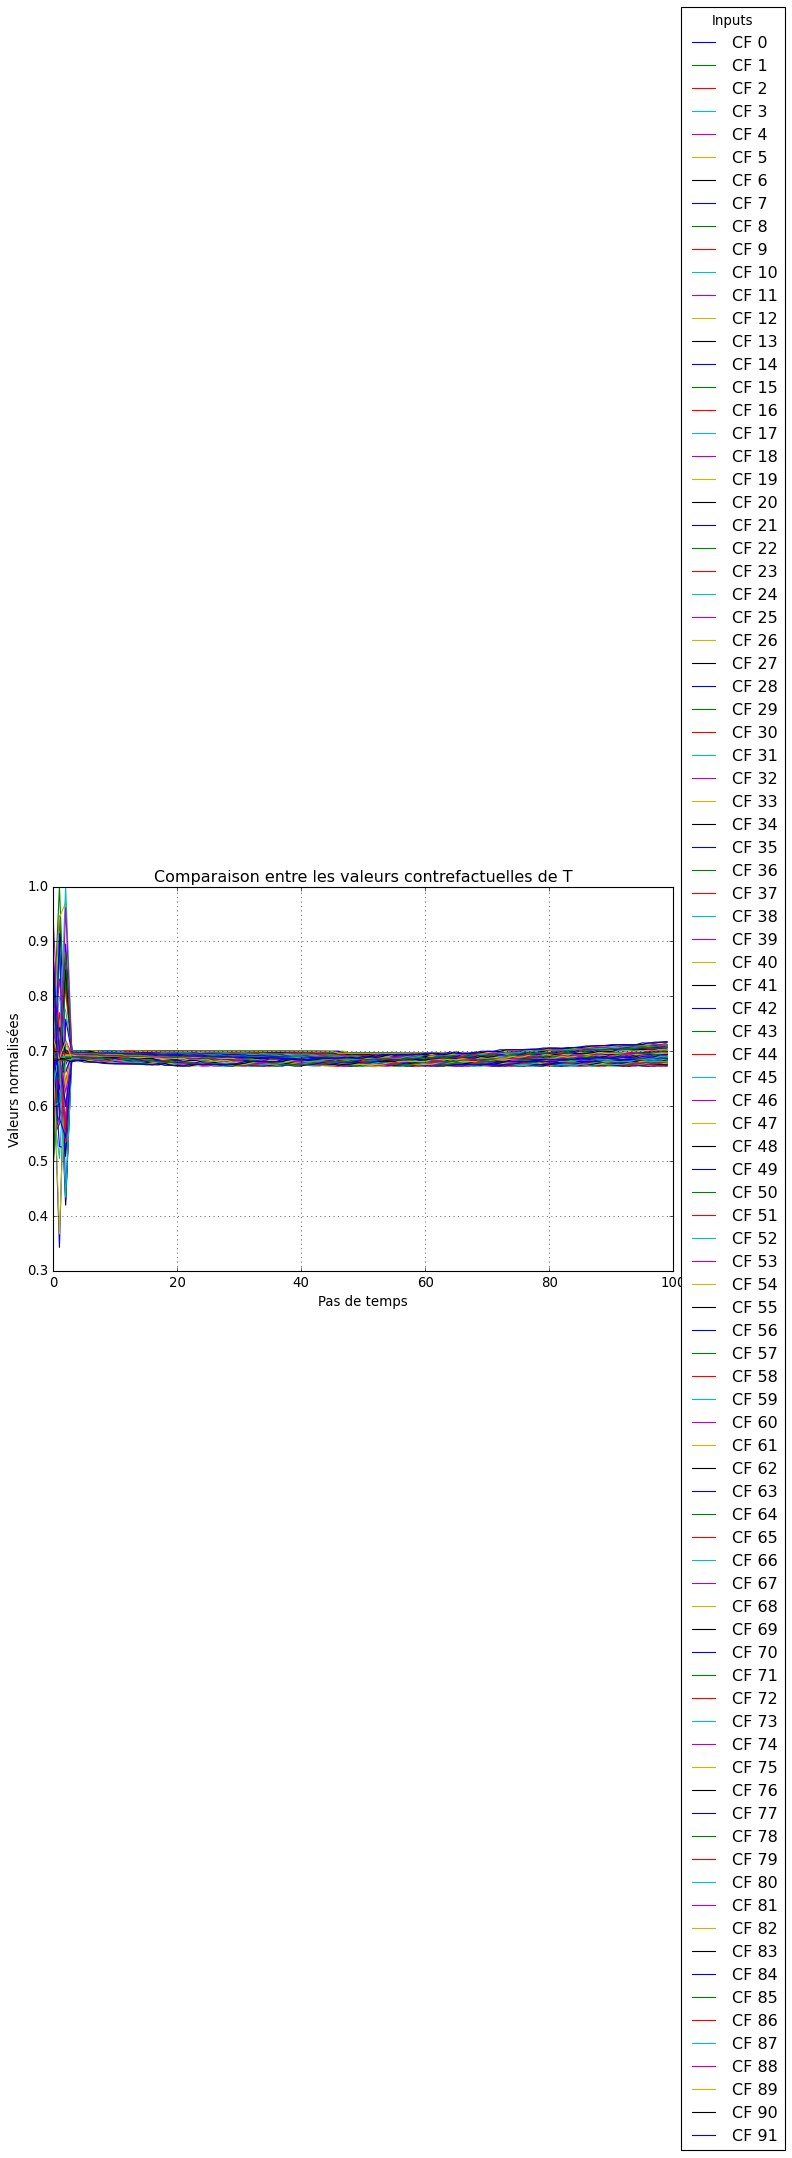

In [48]:
_=NSGA2_method_results(query_instance2=ID,population=population,index=0)

## Middle of Charge: (index = 150).

In [49]:
query_instance1=X1[150]
ID=t[150]
population = X1[100:200]


### GENO-TOPSIS

number of cf generated: 20
Time needed in s: 2102.3817875385284


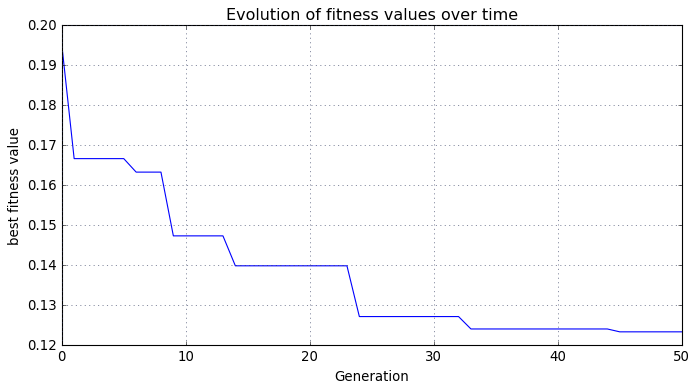

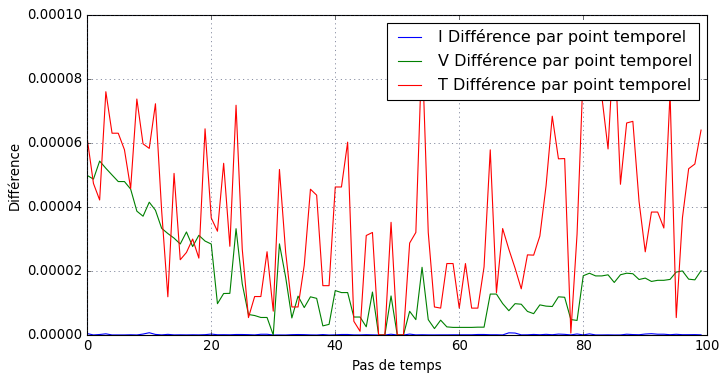

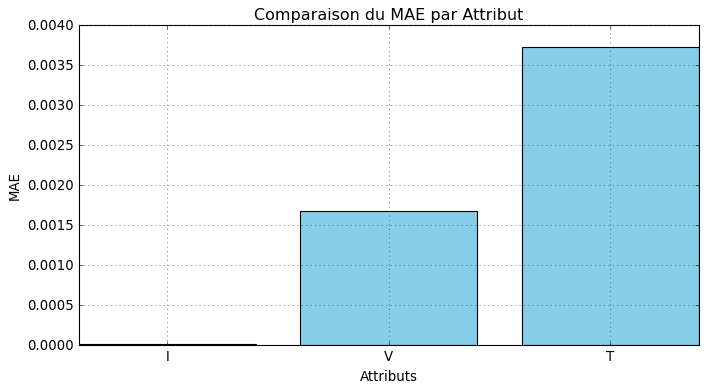

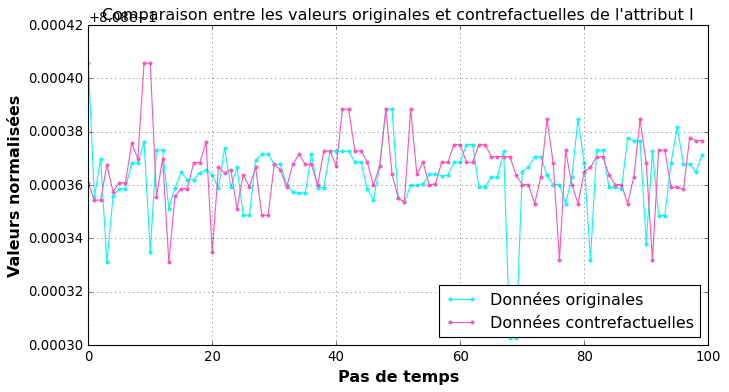

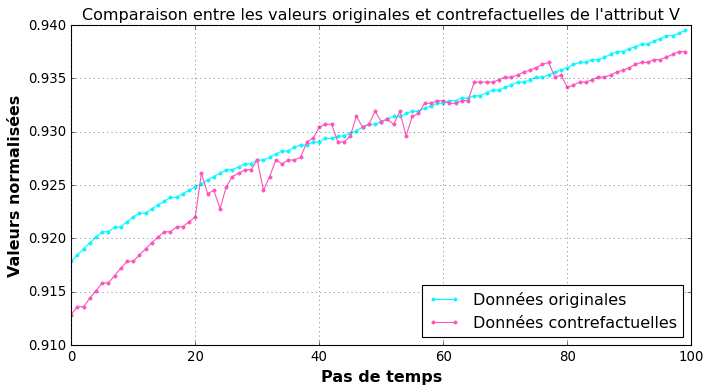

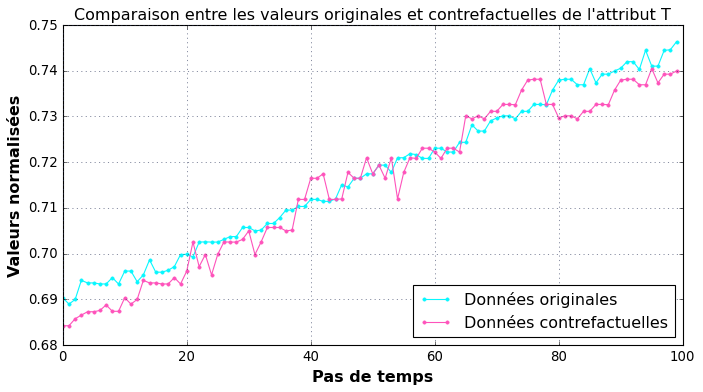

analysing...: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


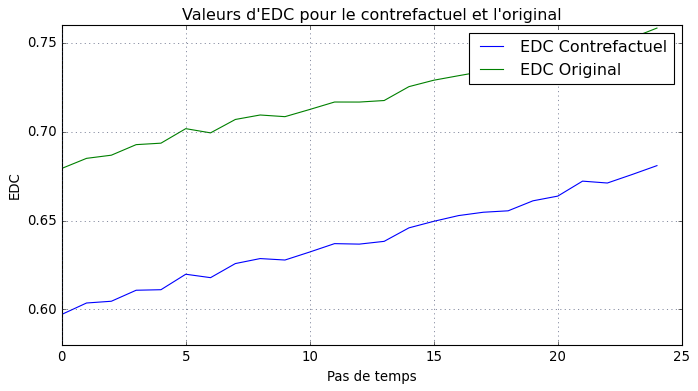

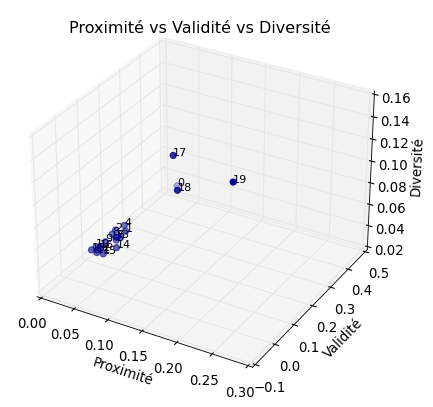

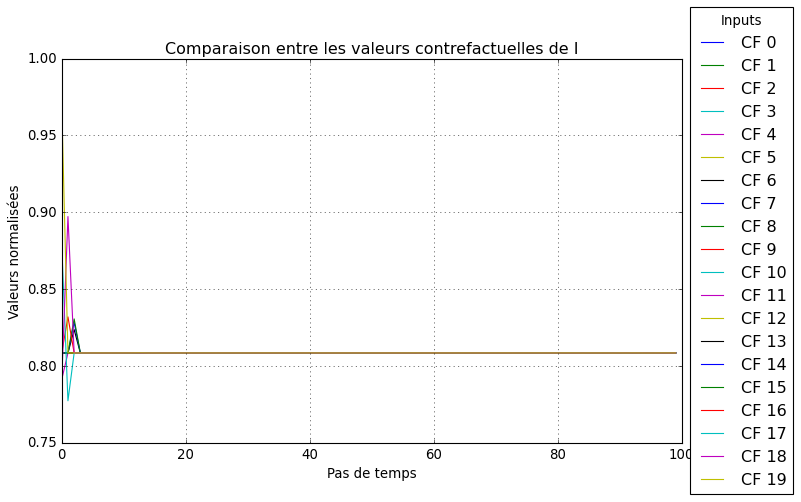

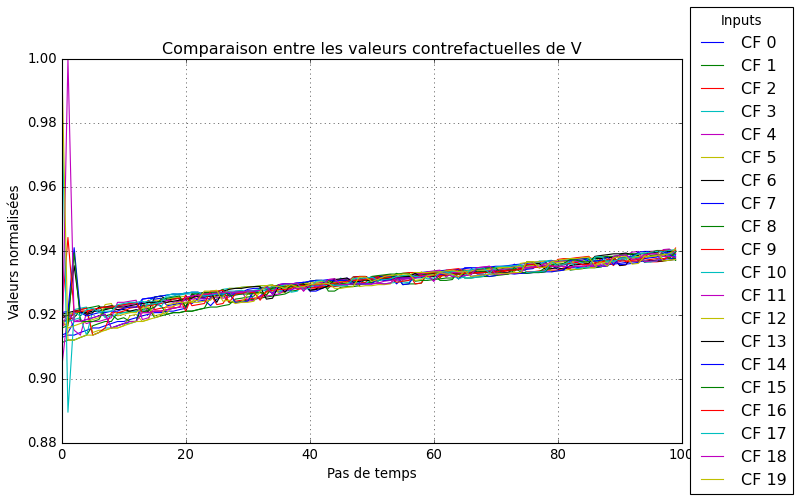

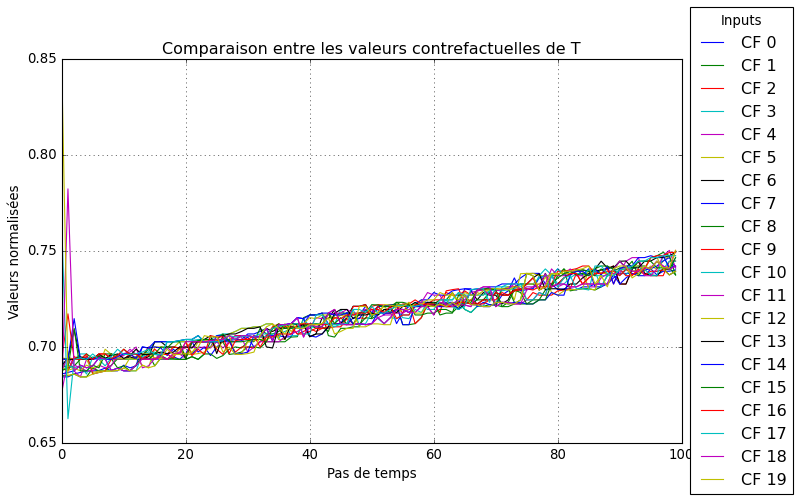

In [50]:
_=GENO_TOPSIS_method_results(query_instance1,population)

### NSGA2

generating...: 100%|███████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


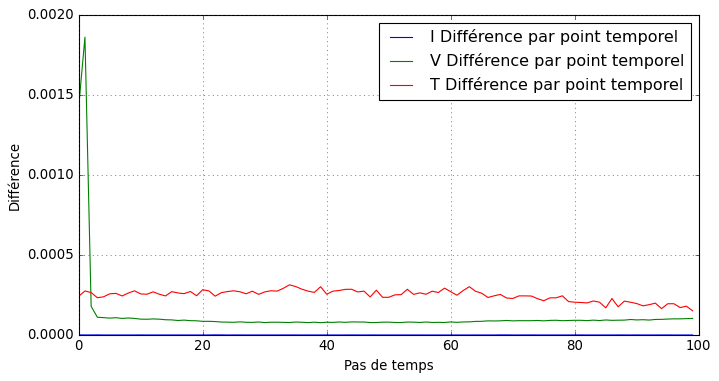

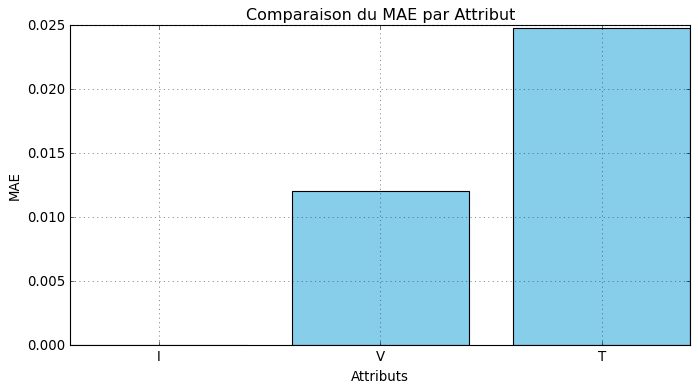

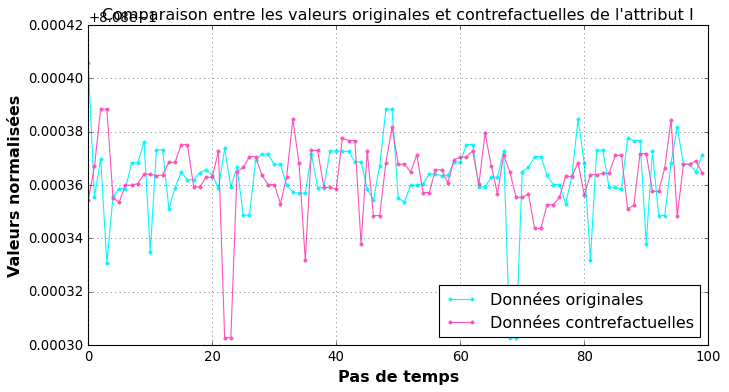

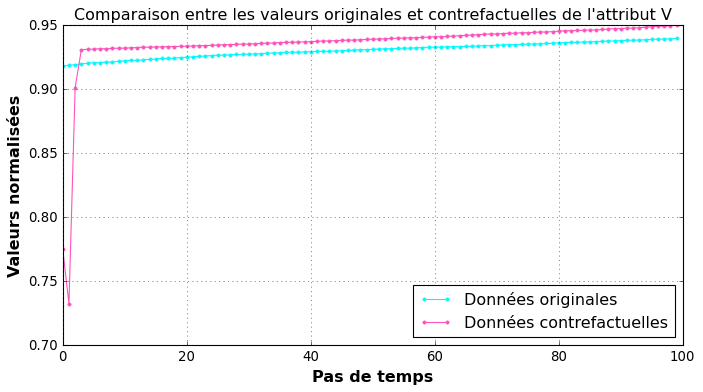

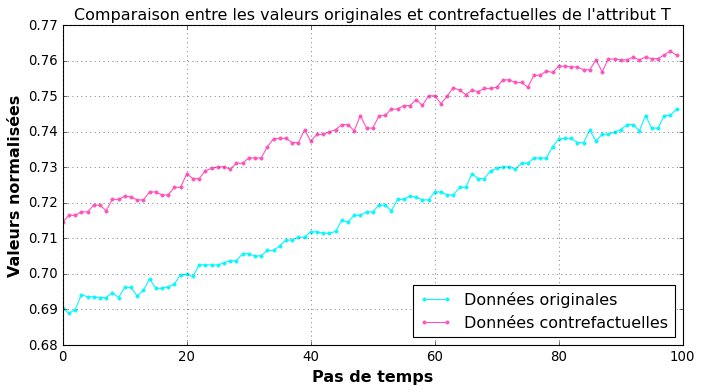

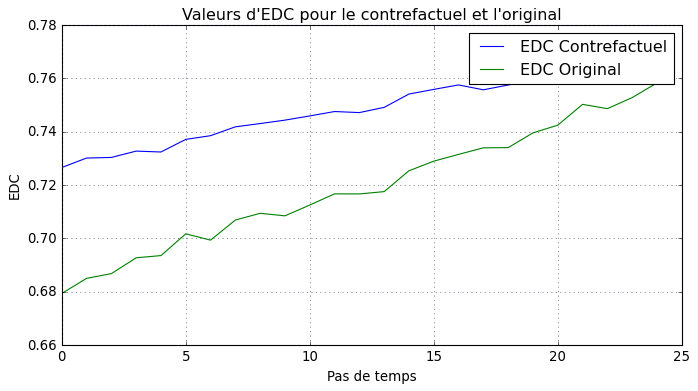

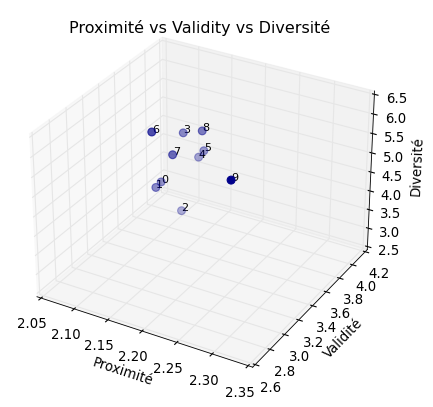

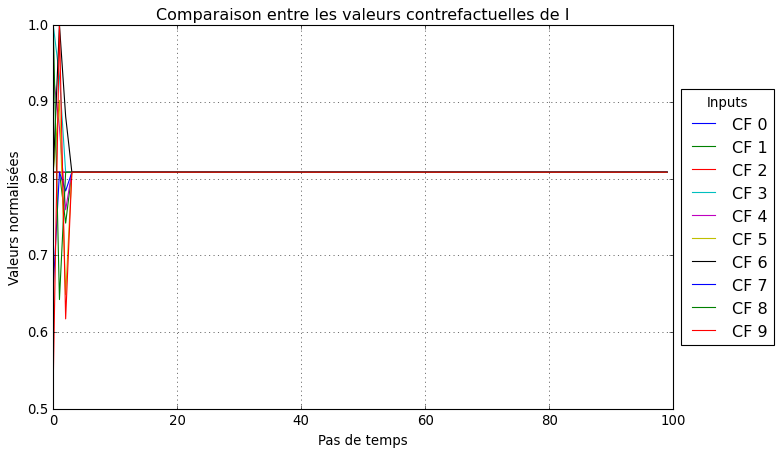

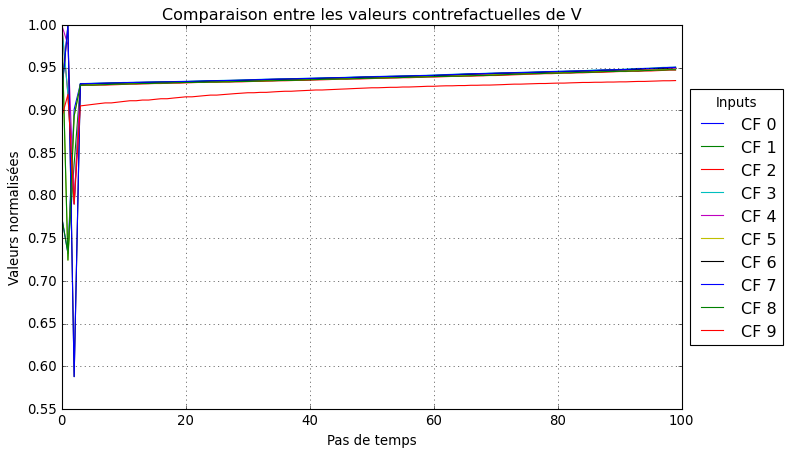

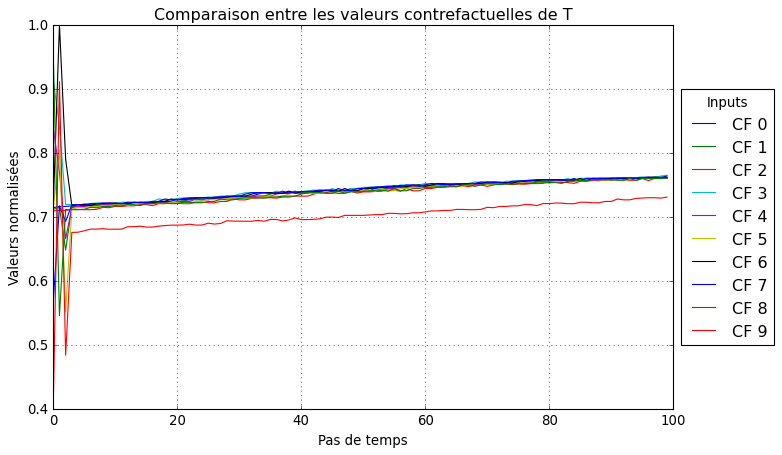

In [51]:
_=NSGA2_method_results(query_instance2=ID,population=population,index=0)

# SOC Near 100%**:(Index = 350)

In [61]:
query_instance1=X1[350]
ID=t[350]
population = X1[300:400]






### GENO-TOPSIS

number of cf generated: 20
Time needed in s: 1986.4606609344482


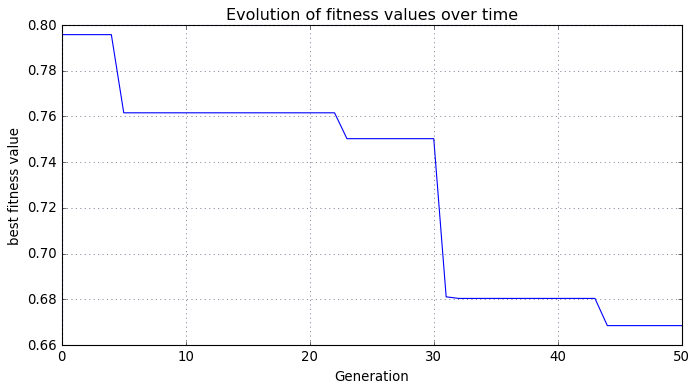

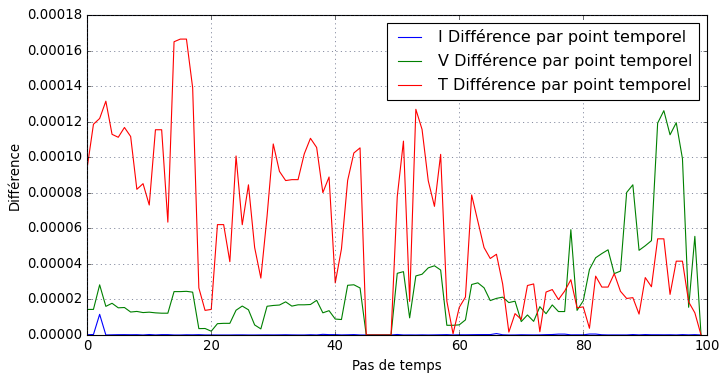

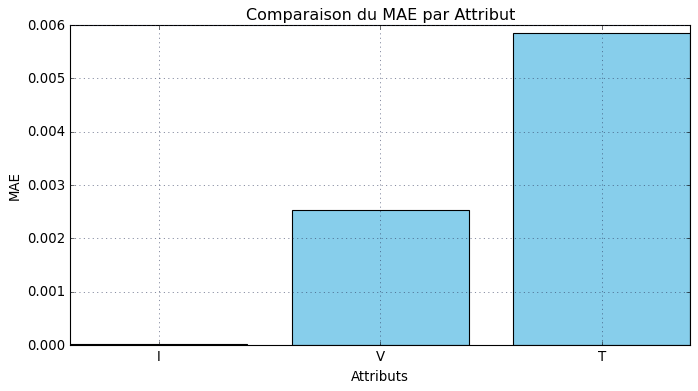

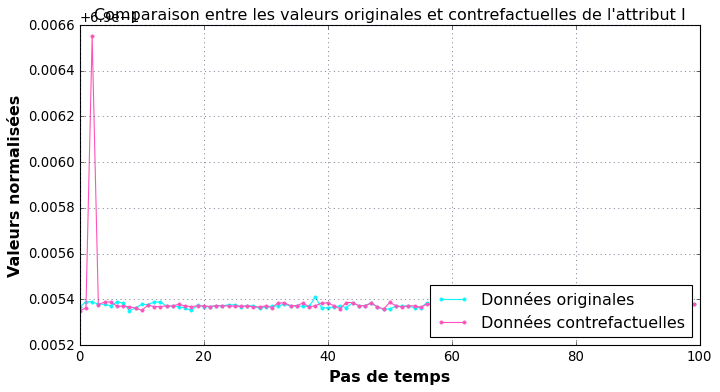

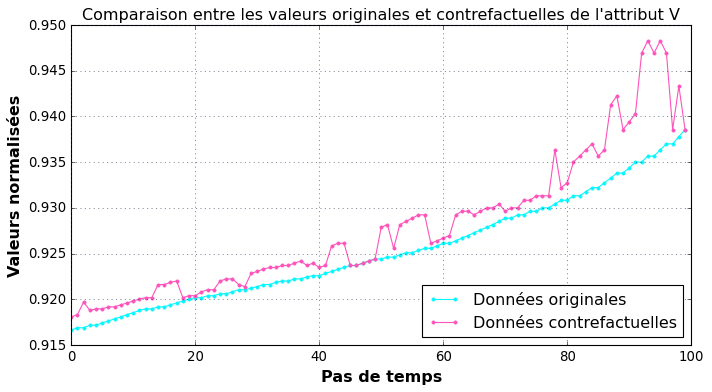

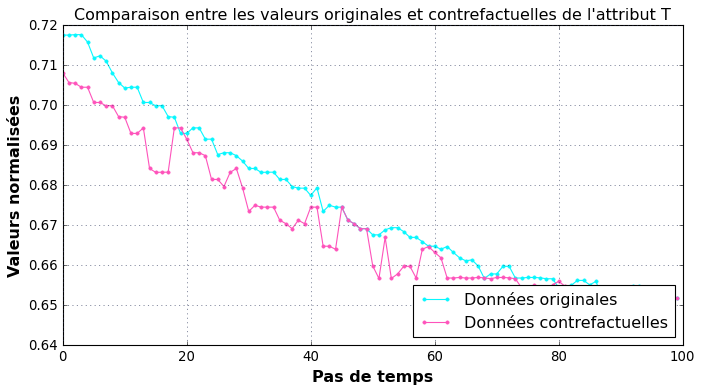

analysing...: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


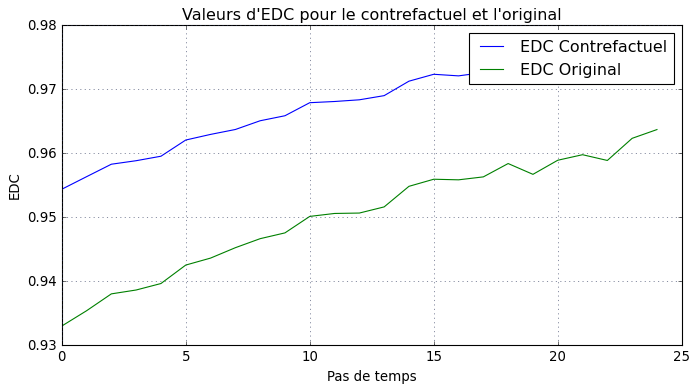

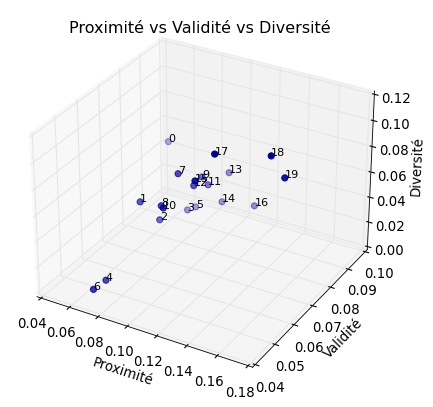

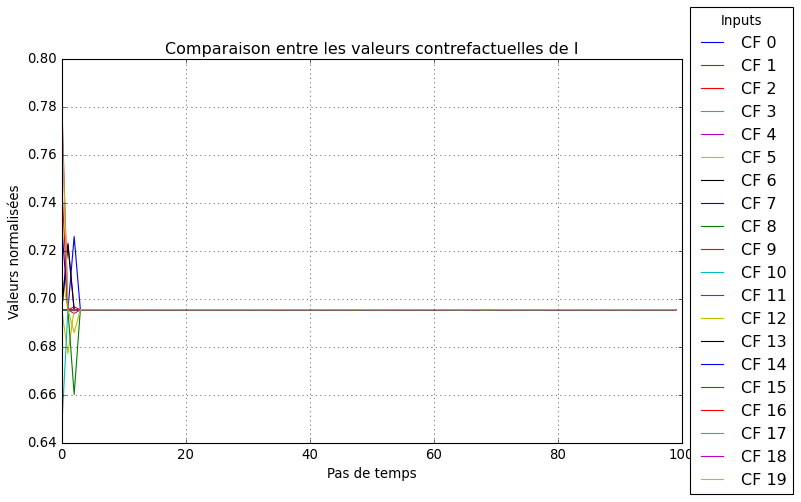

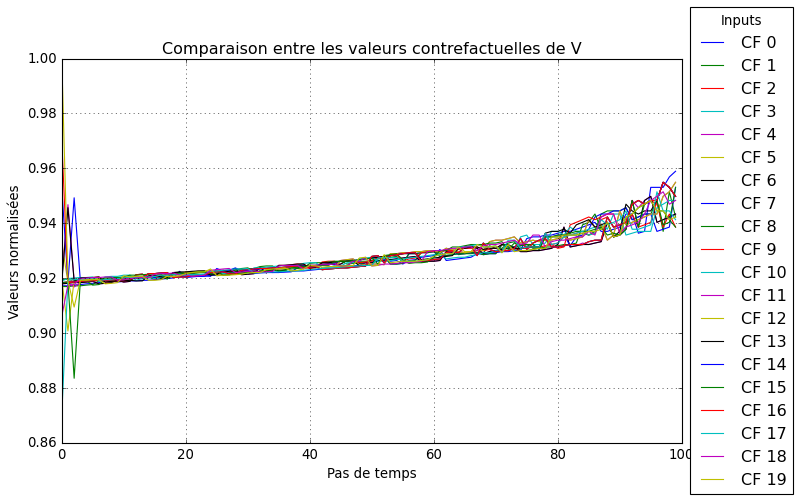

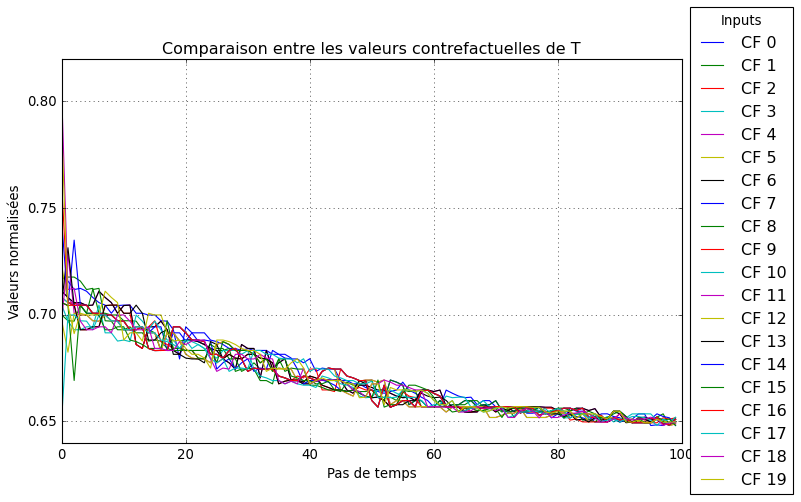

In [62]:
_=GENO_TOPSIS_method_results(query_instance1,population)

### NSGA2

generating...: 100%|███████████████████████████████████████████████████████████████████| 50/50 [02:13<00:00,  2.67s/it]


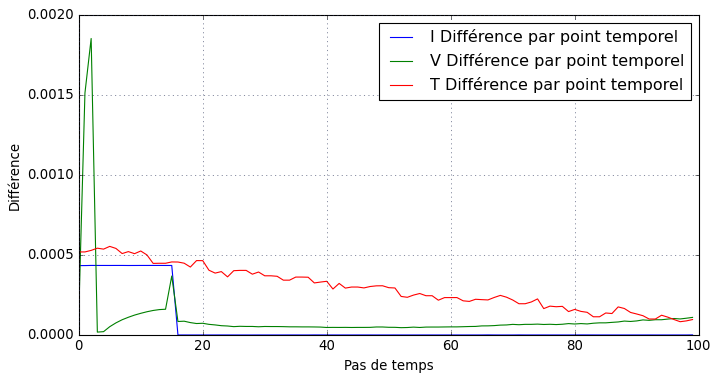

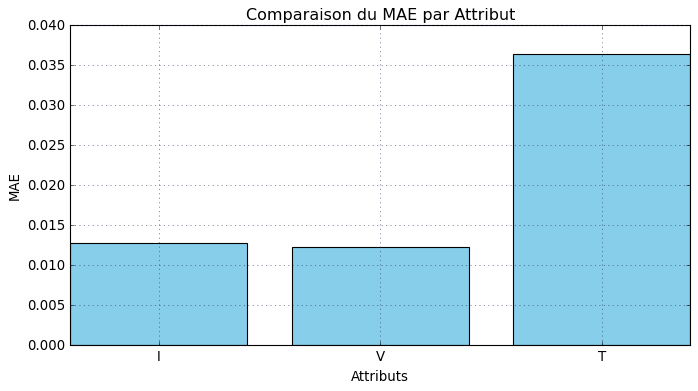

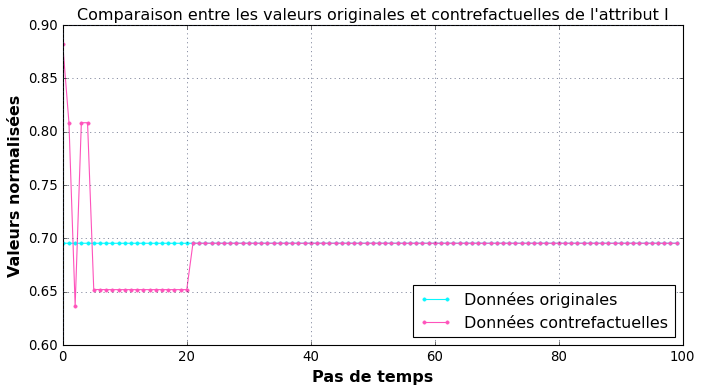

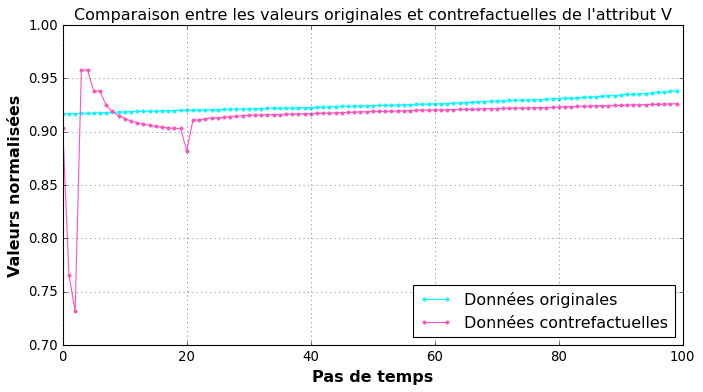

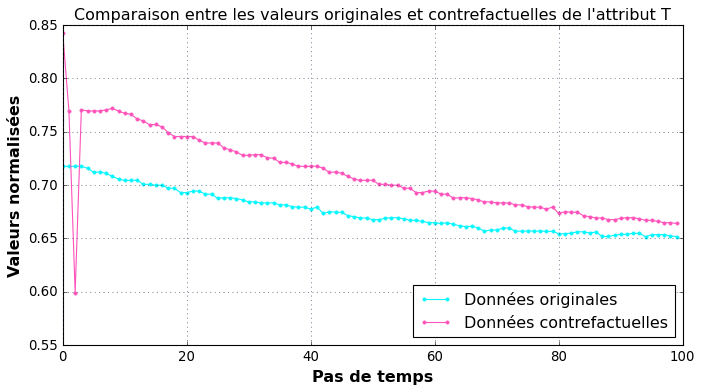

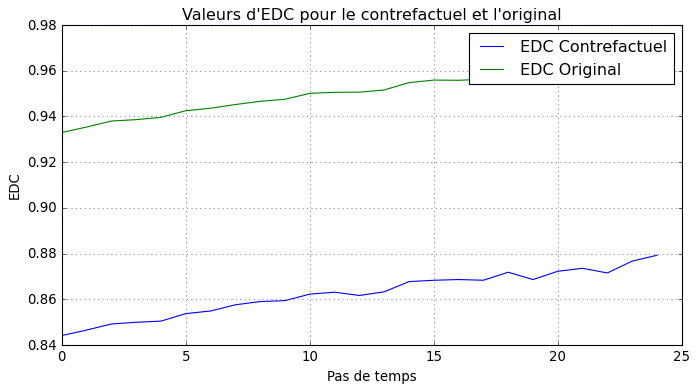

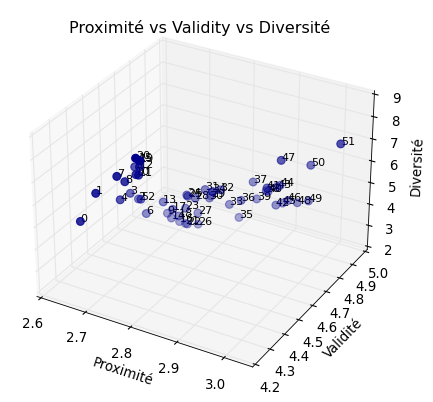

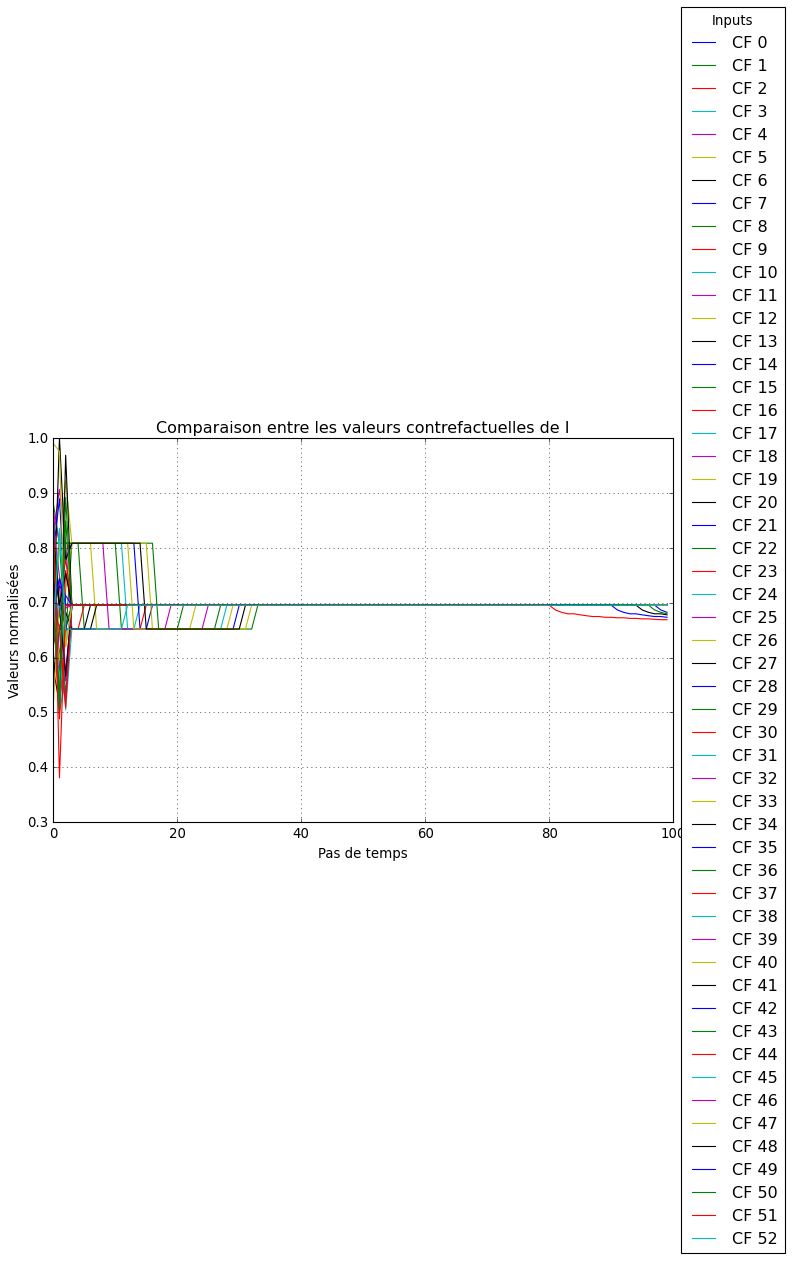

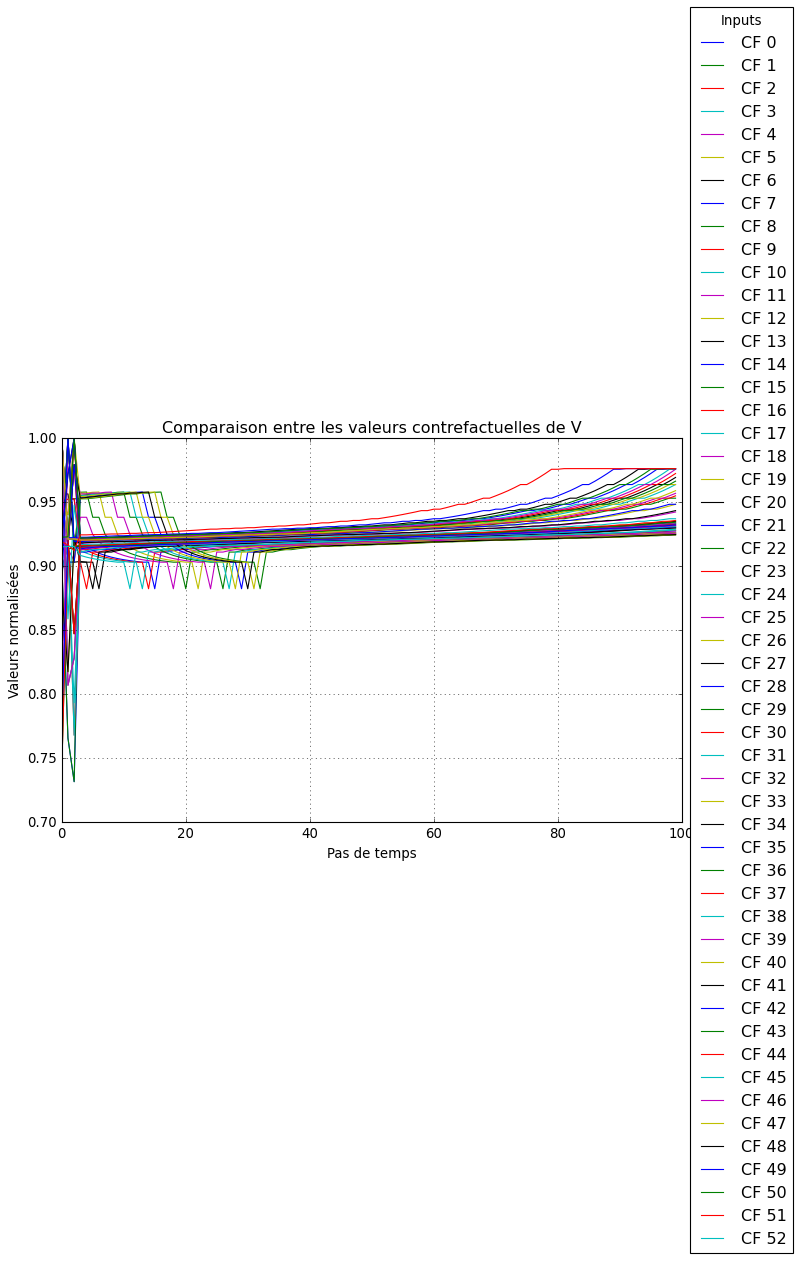

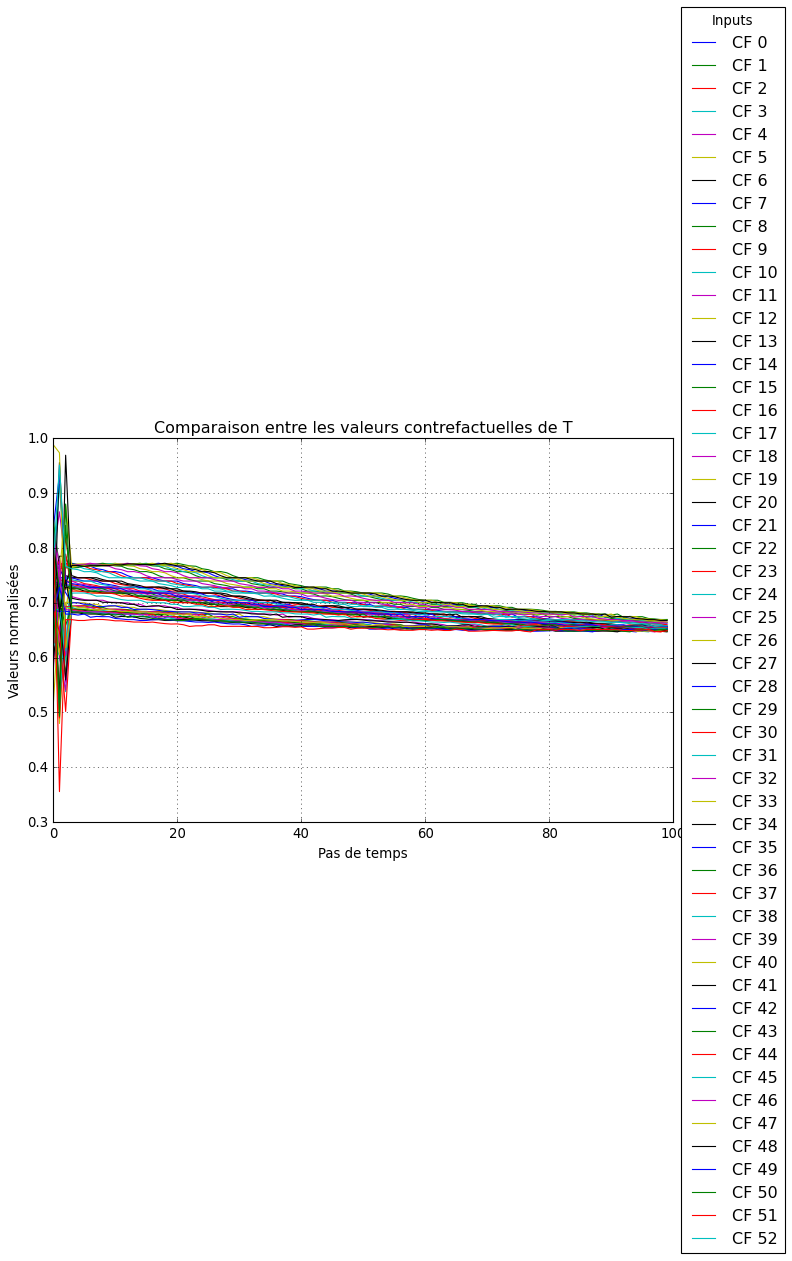

In [54]:
_=NSGA2_method_results(query_instance2=ID,population=population,index=1)

## Constant Current Discharge: (Index = 610 )

In [72]:
query_instance1=X1[710]
ID=t[710]
population = X1[700:800]


### GENO-TOPSIS

number of cf generated: 20
Time needed in s: 2068.684966802597


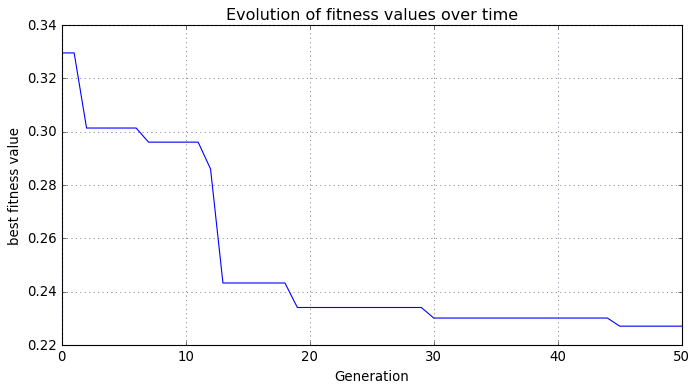

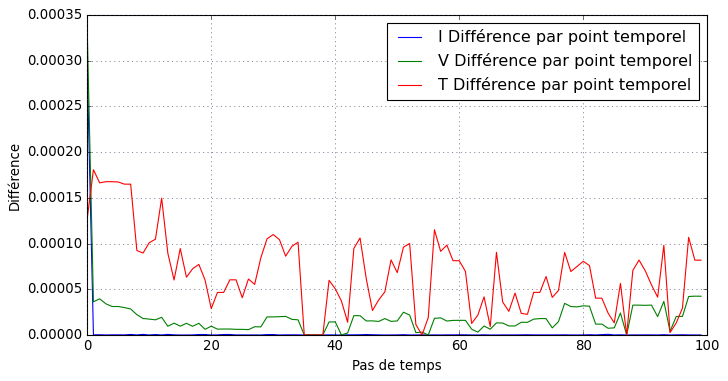

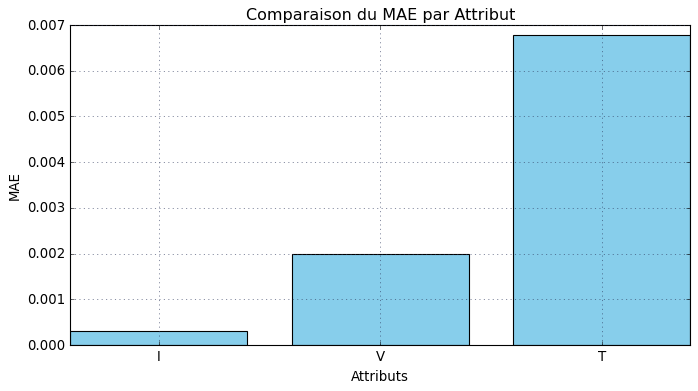

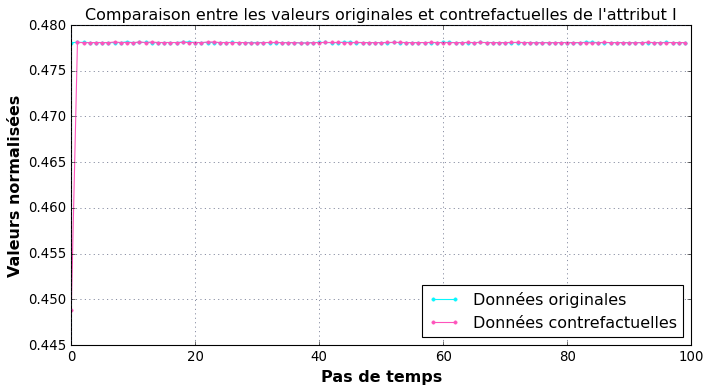

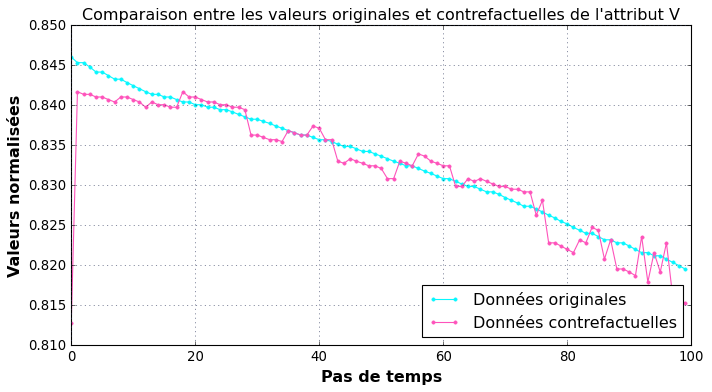

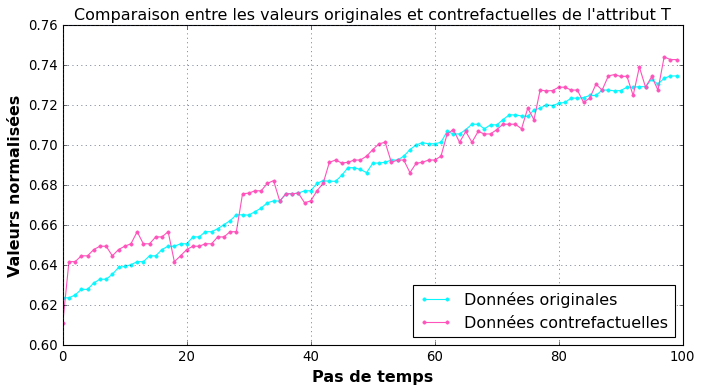

analysing...: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33it/s]


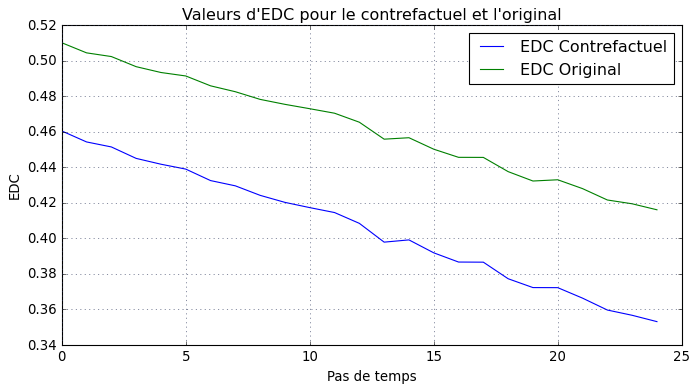

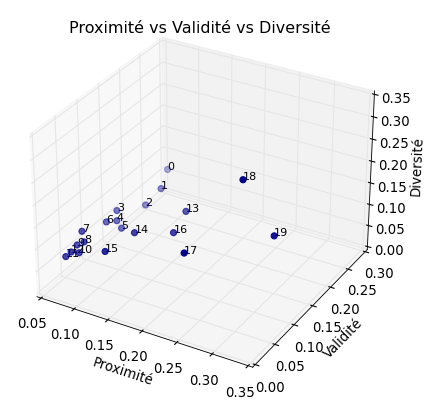

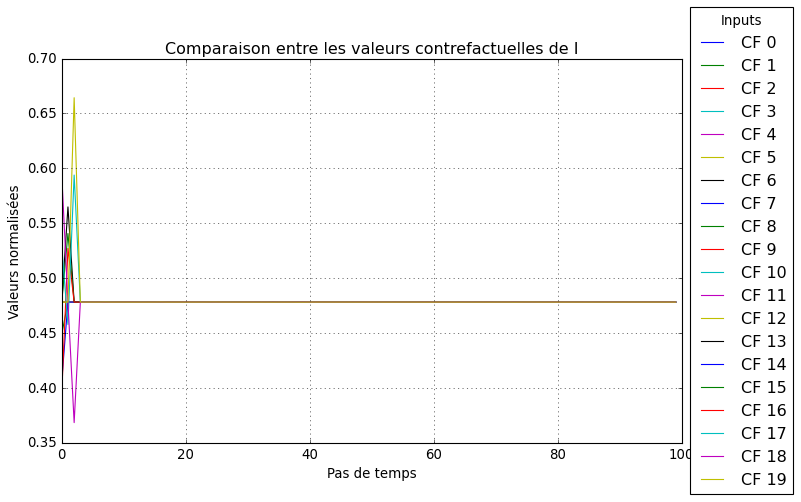

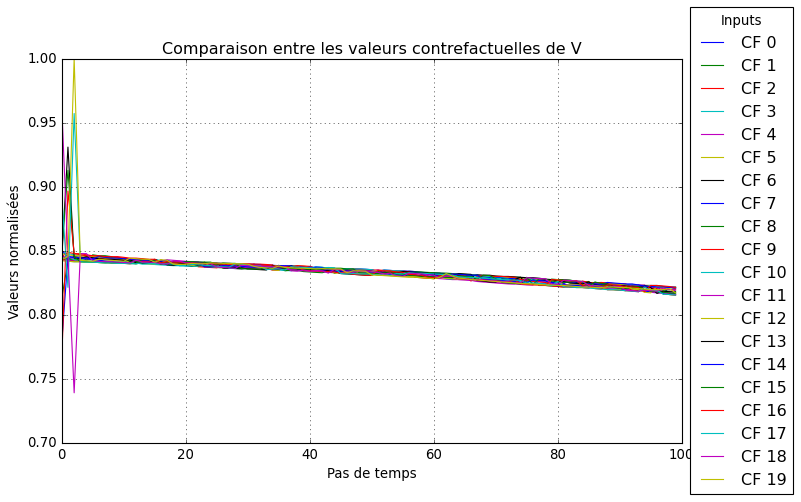

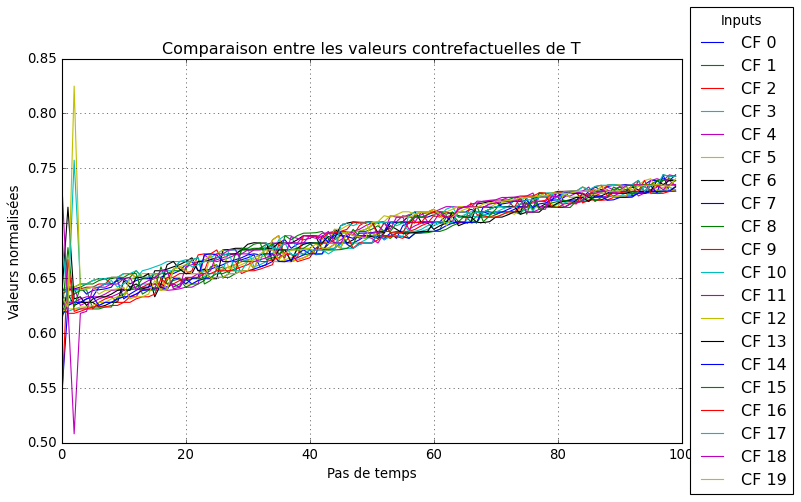

In [74]:
_=GENO_TOPSIS_method_results(query_instance1,population)

### NSGA2

generating...: 100%|███████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.76s/it]


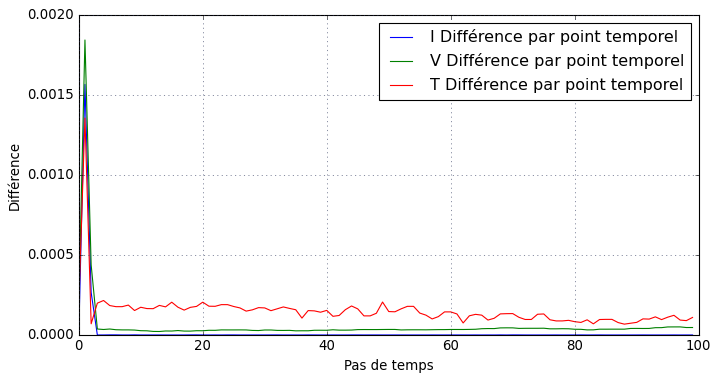

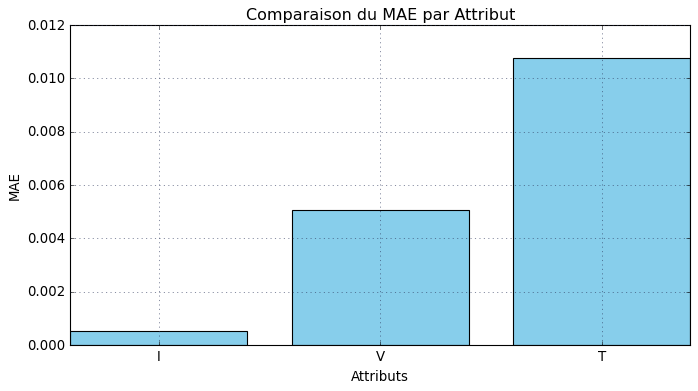

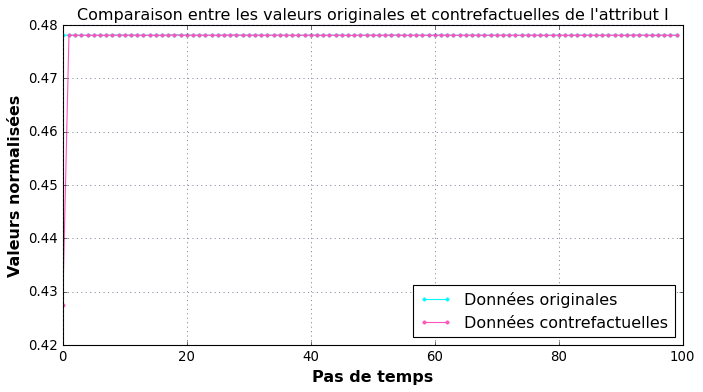

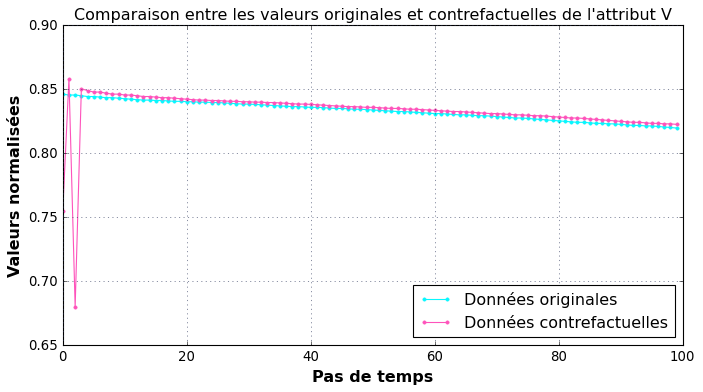

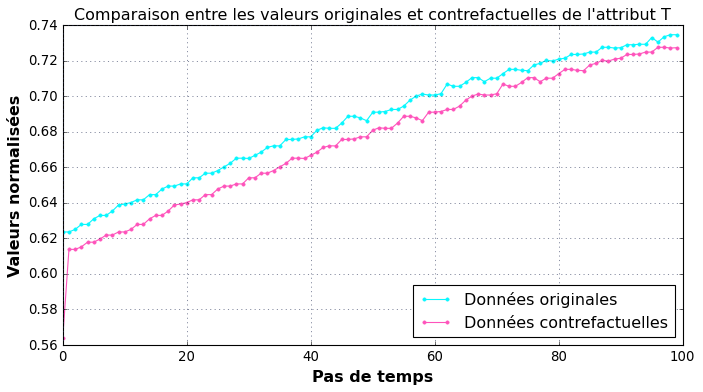

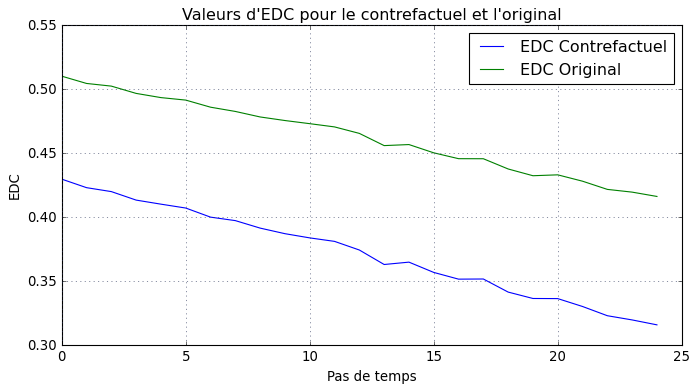

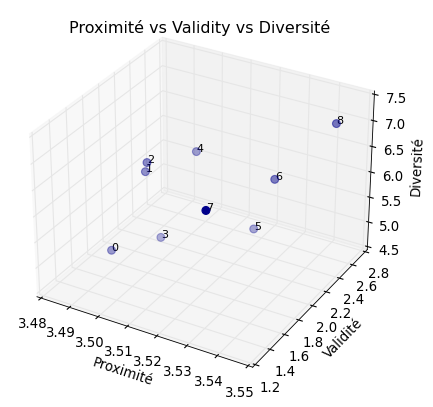

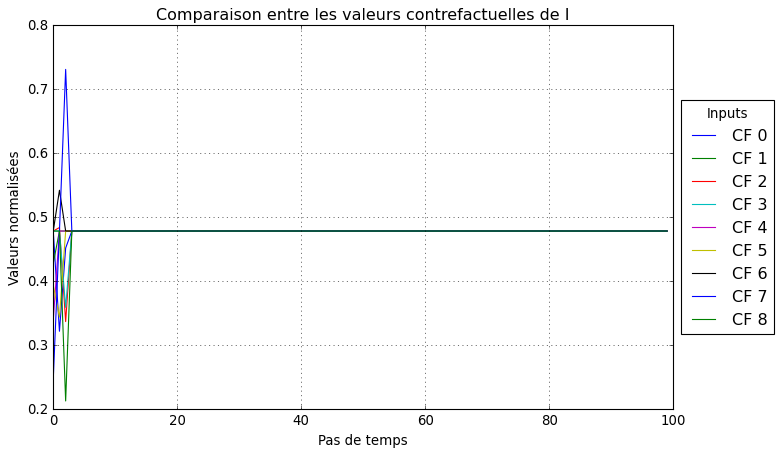

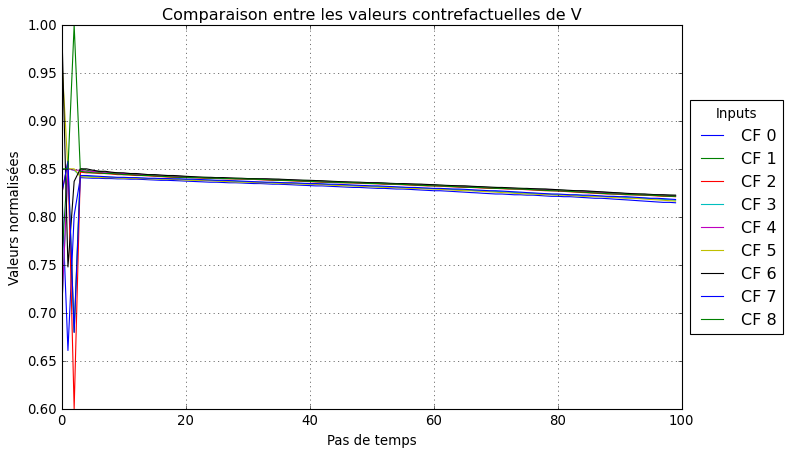

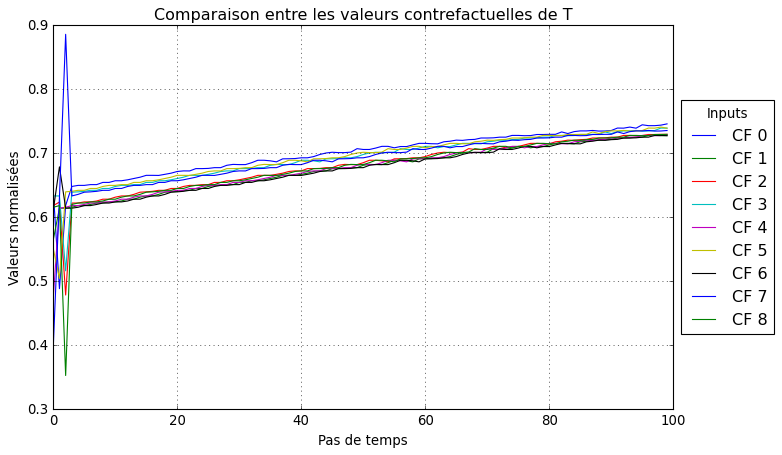

In [73]:
_=NSGA2_method_results(query_instance2=ID,population=population,index=1)

## non Constant Current Discharge: (Index = 610 )

In [79]:
train_data=[I1,V1,T1,SOC1]

In [80]:
I=[]
V=[]
T=[]
SOC=[]
time=[]
for i in range(len(train_data[0])):
    for j in range(len(train_data[3][i])):
        I.append(train_data[0][i][j])
        V.append(train_data[1][i][j])
        T.append(train_data[2][i][j])
        SOC.append(train_data[3][i][j])
        #time.append(train_data[4][i][j])

In [81]:
df_train=pd.DataFrame({"I":I,"V":V,"T":T,"SOC":SOC})

In [106]:
mini,minv,mint,maxi,maxv,maxt=np.load("min_max_soc.npy")

In [82]:
df_train["I"]=(df_train["I"]-mini)/(maxi-mini)
df_train["V"]=(df_train["V"]-minv)/(maxv-minv)
df_train["T"]=(df_train["T"]-mint)/(maxt-mint)

In [83]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
input_step=100
output_step=25
X_train,Y_train,time=split_sequence(df_train,input_step,output_step)

In [84]:
t=np.zeros((len(X_train),3,100))
for i in range(len(X_train)):
    for j in range(100):
        t[i][0][j]=X_train[i][j][0]
        t[i][1][j]=X_train[i][j][1]
        t[i][2][j]=X_train[i][j][2]

In [112]:
X1=np.float32(X_train)
Y1=np.float32(Y_train)

In [117]:
query_instance1=X1[4800]
ID=t[4800]
population = X1[4600:4700]

### GENO-TOPSIS

number of cf generated: 20
Time needed in s: 2386.5962619781494


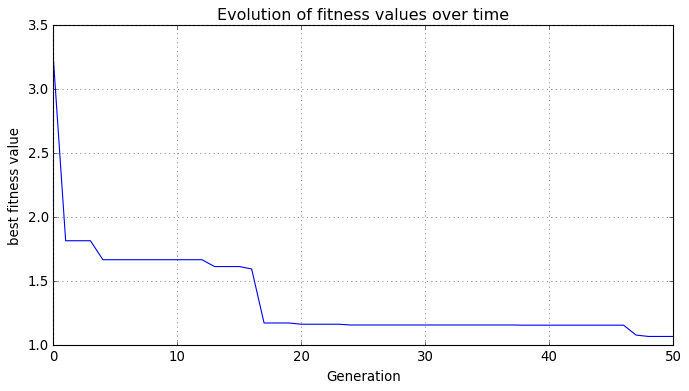

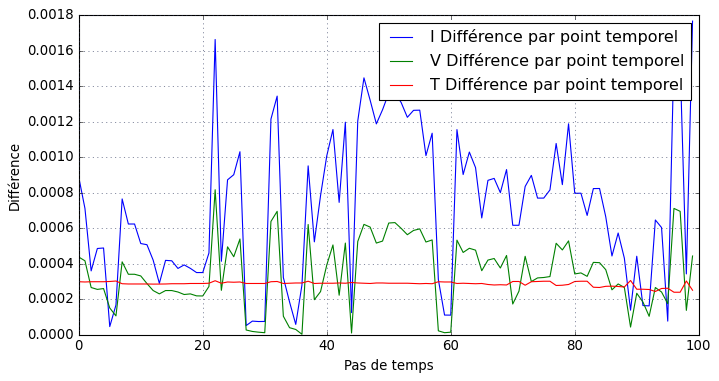

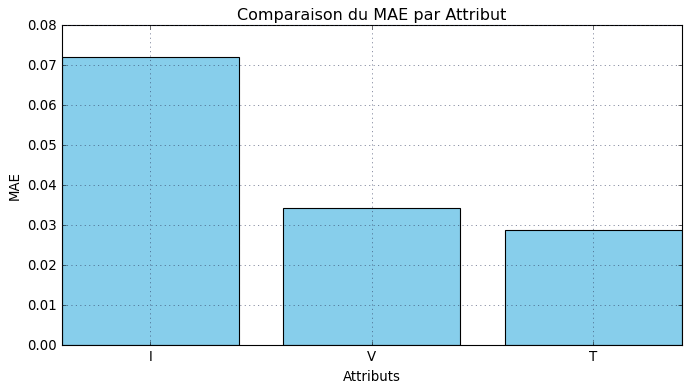

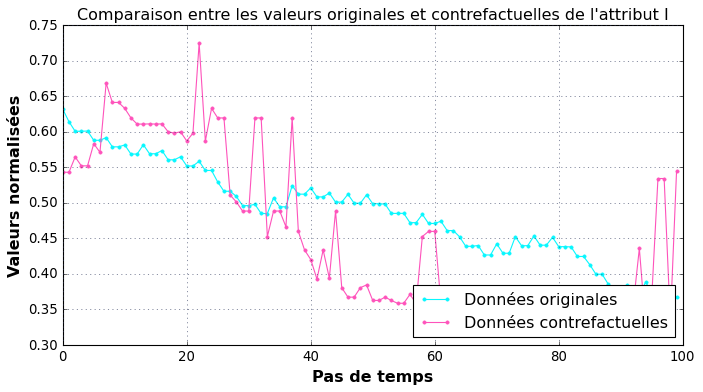

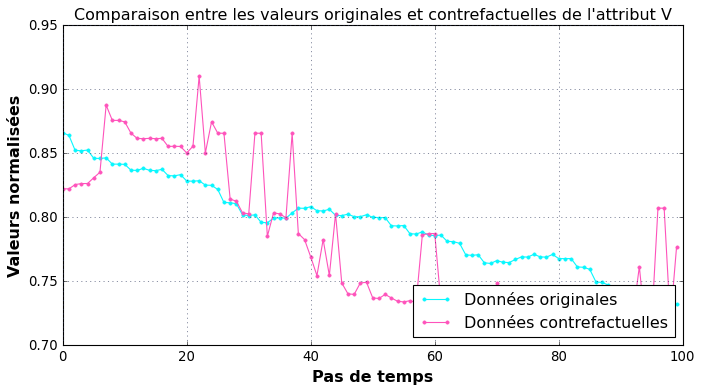

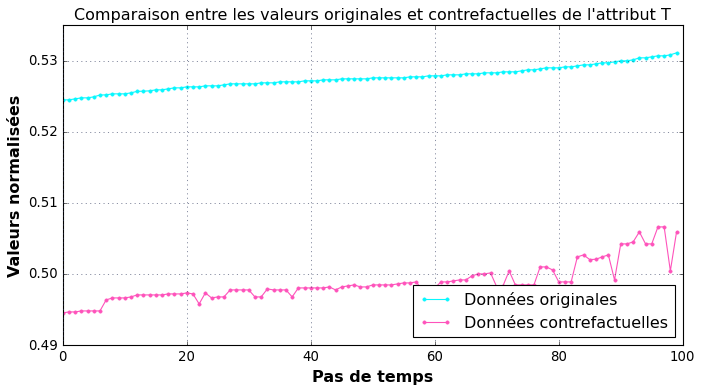

analysing...: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


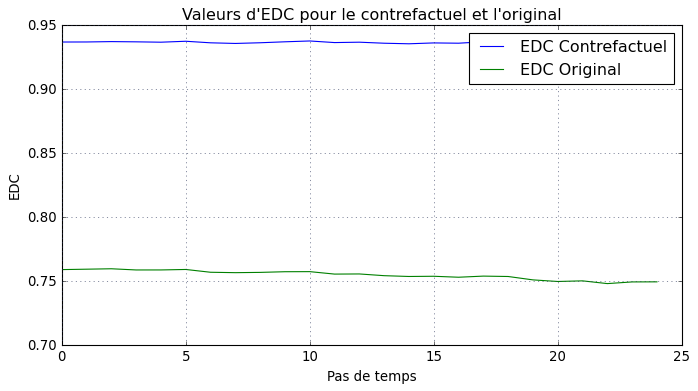

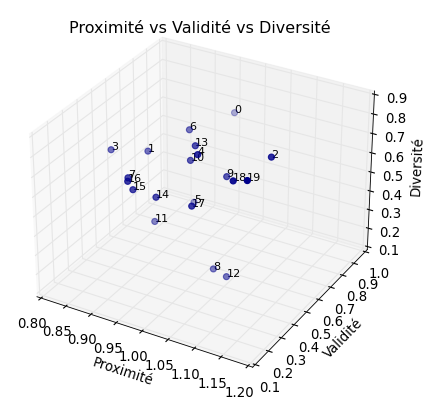

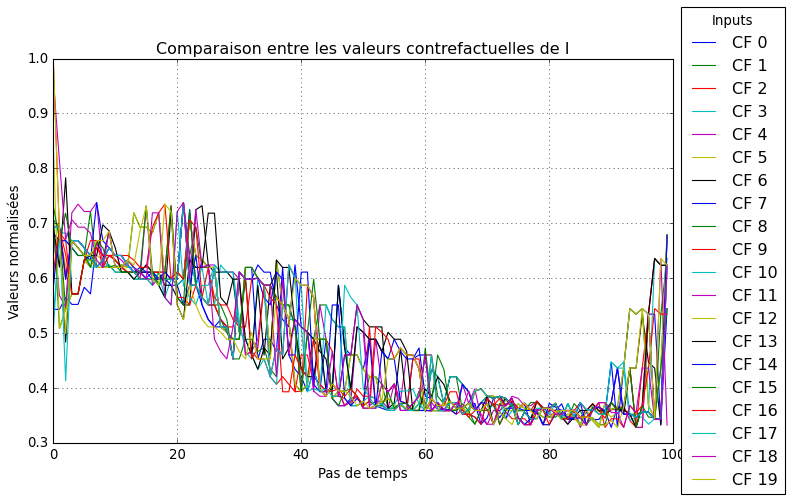

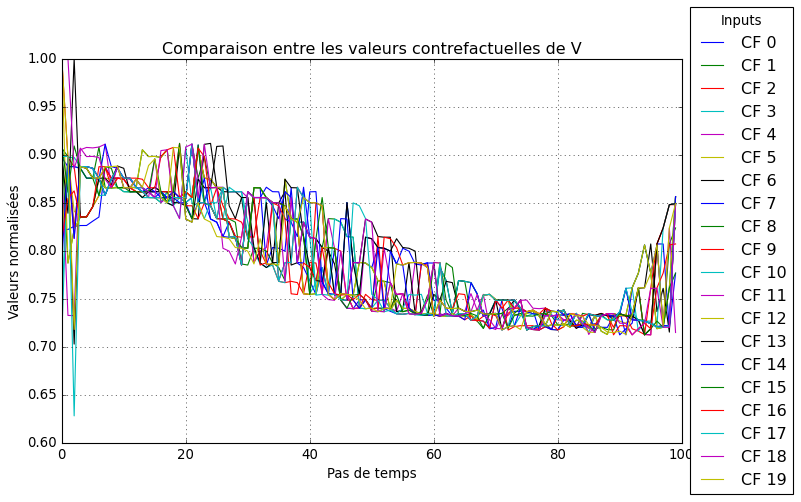

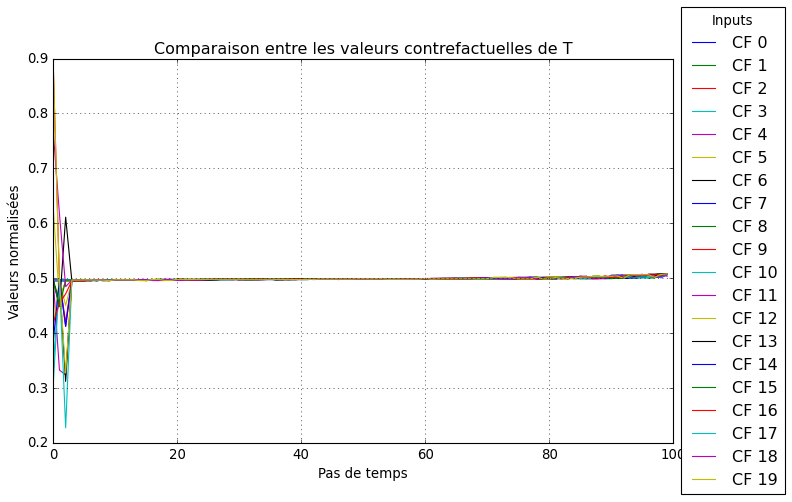

In [121]:
_=GENO_TOPSIS_method_results(query_instance1,population)

### NSGA2

generating...: 100%|███████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.81s/it]


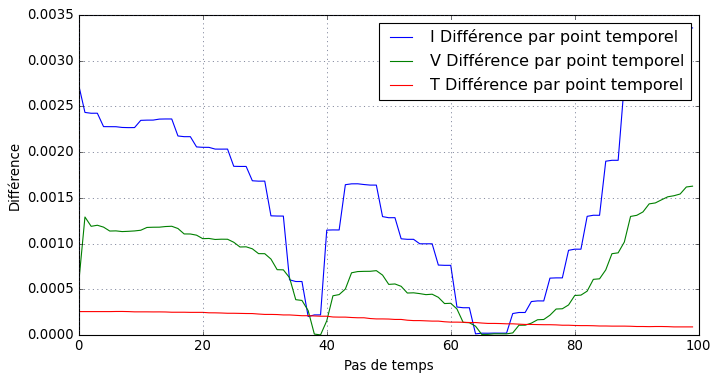

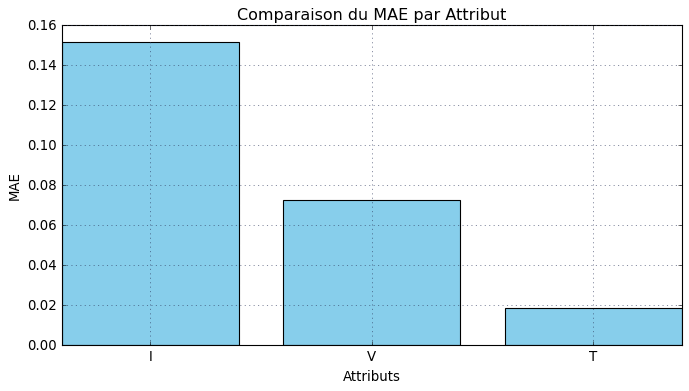

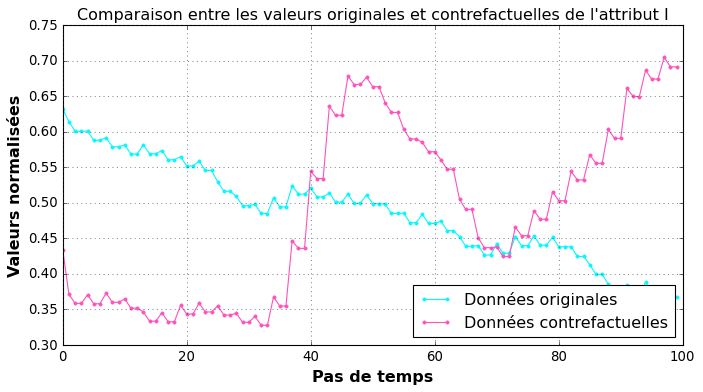

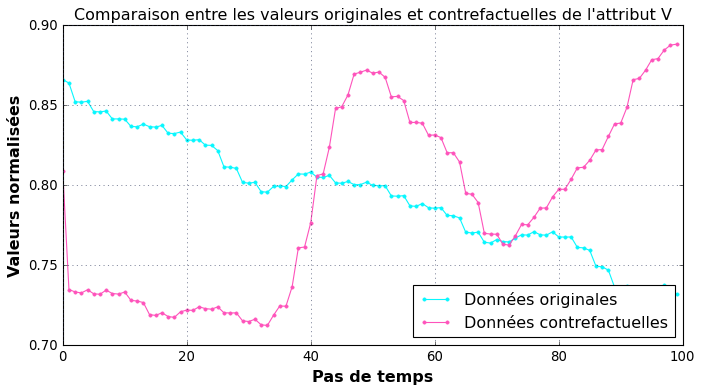

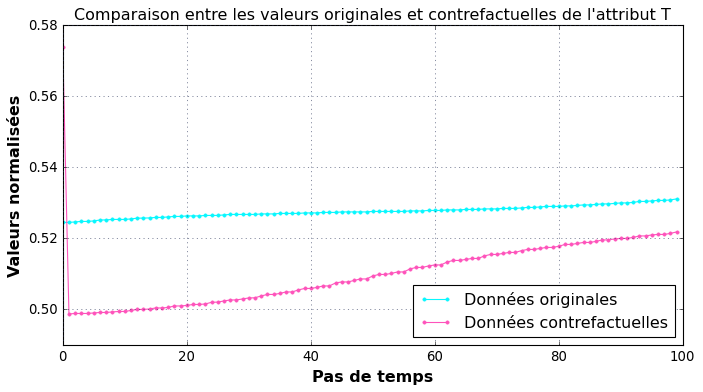

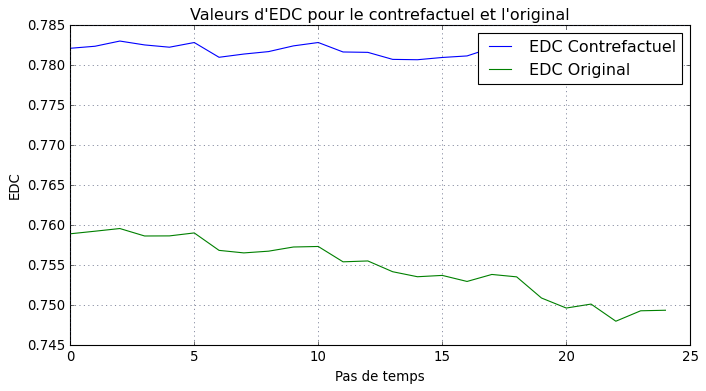

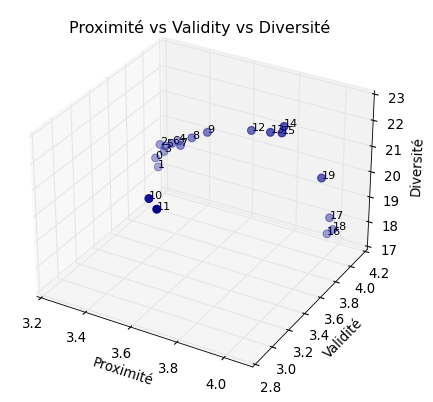

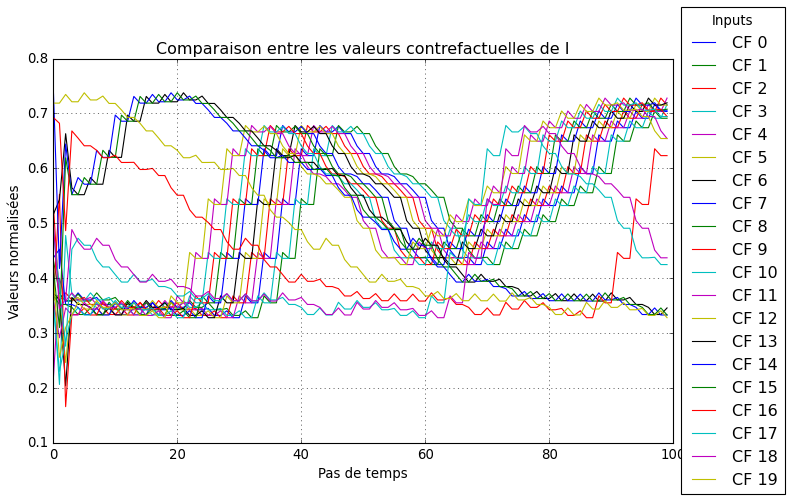

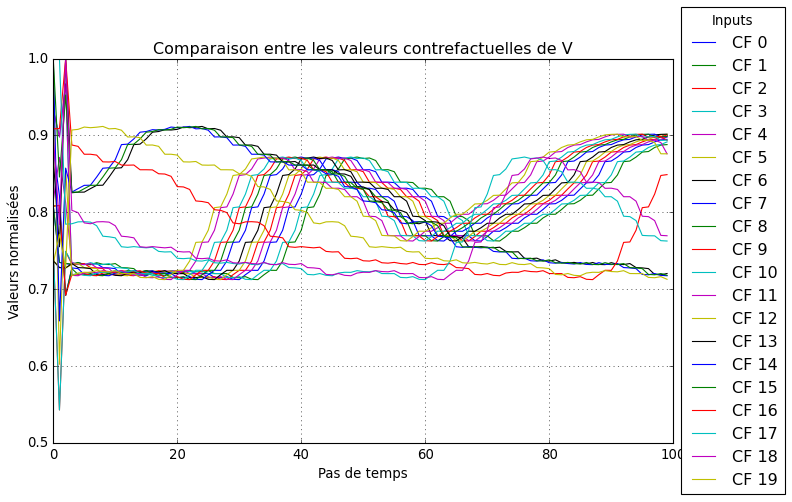

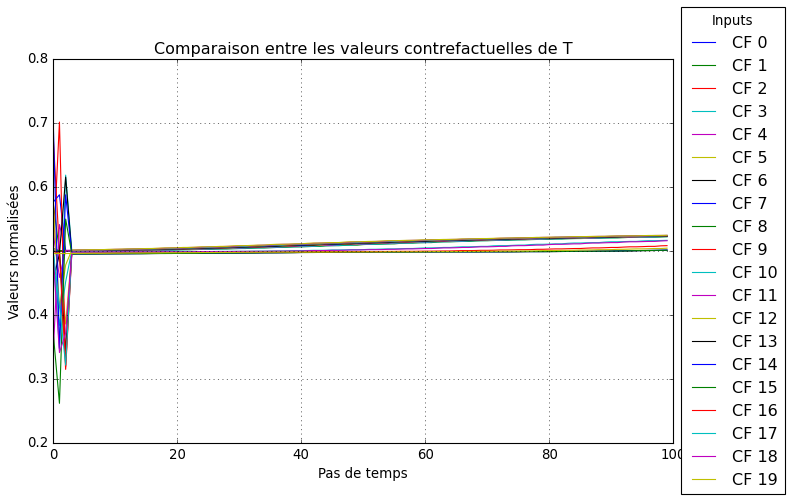

In [118]:
_=NSGA2_method_results(query_instance2=ID,population=population,index=1)